In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !unzip /content/gdrive/MyDrive/radiusai/dataset.zip > /dev/null

In [ ]:
# Import Libraries

import matplotlib.pylab as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keract import display_activations, get_activations

In [ ]:
# Read image paths

imagePaths=[]
for root, dirnames, filenames in os.walk(r'../dataset'):
    for filename in filenames:
        if (filename[-3:] == 'jpg'):
            imagePaths.append(os.path.join(root, filename))
            
print(len(imagePaths))

25260


In [ ]:
image=plt.imread(imagePaths[0])
image.shape

(128, 64, 3)

In [ ]:
# AutoEncoder

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Dense, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_shape=(64, 64, 3)
encoding_dim = 32

# Encoder
encoder = Sequential([
    Conv2D(input_shape=input_shape, filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='LeakyReLU', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='LeakyReLU', padding='same'),
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='LeakyReLU'),
    BatchNormalization(),
    Dense(128, activation='LeakyReLU'),
    Dense(encoding_dim, activation='LeakyReLU')
])

# Decoder
decoder = Sequential([
    Dense(128, activation='LeakyReLU', input_shape=(encoding_dim,)),
    BatchNormalization(),
    Dense(256, activation='LeakyReLU'),
    BatchNormalization(),
    Dense(16*16*3, activation='LeakyReLU'),
    Reshape((16, 16, 3)),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='LeakyReLU', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='LeakyReLU', padding='same'),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

# Compile the model

autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))
autoencoder_dr.compile(optimizer=Adam(learning_rate=0.001), loss = 'mae')

In [ ]:
autoencoder_dr.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6_input (InputLayer)  [(None, 64, 64, 3)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 16)        462

In [ ]:
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               4224      
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 768)               197376    
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 3)        

In [ ]:
#Early Sopping

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
from sklearn.model_selection import train_test_split

# Test Train Split

imagePathsTrain, imagePathsTest = train_test_split(imagePaths, test_size=0.1, random_state=42)
print(len(imagePathsTrain), len(imagePathsTest))

22734 2526


In [ ]:
x_train = []
x_val = []
train = []

for i in range(len(imagePathsTrain)):
  if i%7000 == 0 and i!=0:
    # Train the autoencoder
    x_train, x_val = train_test_split(train, test_size=0.1, random_state=42)
    x_train = np.array(x_train)
    x_val = np.array(x_val)
    print(np.array(train).shape, x_train.shape, x_val.shape, i)
    autoencoder_dr.fit(x_train, x_train, epochs=100, batch_size=64, shuffle=True, validation_data=(x_val, x_val), callbacks=[es])
    train = []
    x_train = []
    x_val = []
  try:
    # Process the images
    image=plt.imread(imagePaths[i])
    image=cv2.resize(image, (64, 64))
    image = image/255
    train.append(image)
  except:
    pass
x_train, x_val = train_test_split(train, test_size=0.2, random_state=42)
x_train = np.array(x_train)
x_val = np.array(x_val)
print(np.array(train).shape, x_train.shape, x_val.shape)
autoencoder_dr.fit(x_train, x_train, epochs=100, batch_size=32, shuffle=True, validation_data=(x_val, x_val), callbacks=[es])

(7000, 64, 64, 3) (6300, 64, 64, 3) (700, 64, 64, 3) 7000
Epoch 1/100
99/99 [==============================] - 10s 34ms/step - loss: 0.1198 - val_loss: 0.1543
Epoch 2/100
99/99 [==============================] - 3s 31ms/step - loss: 0.1028 - val_loss: 0.1383
Epoch 3/100
99/99 [==============================] - 3s 31ms/step - loss: 0.0986 - val_loss: 0.1248
Epoch 4/100
99/99 [==============================] - 3s 33ms/step - loss: 0.0963 - val_loss: 0.1119
Epoch 5/100
99/99 [==============================] - 3s 31ms/step - loss: 0.0945 - val_loss: 0.1044
Epoch 6/100
99/99 [==============================] - 3s 31ms/step - loss: 0.0930 - val_loss: 0.1015
Epoch 7/100
99/99 [==============================] - 3s 31ms/step - loss: 0.0919 - val_loss: 0.0924
Epoch 8/100
99/99 [==============================] - 3s 33ms/step - loss: 0.0915 - val_loss: 0.0993
Epoch 9/100
99/99 [==============================] - 3s 33ms/step - loss: 0.0906 - val_loss: 0.0945
Epoch 10/100
99/99 [=====================

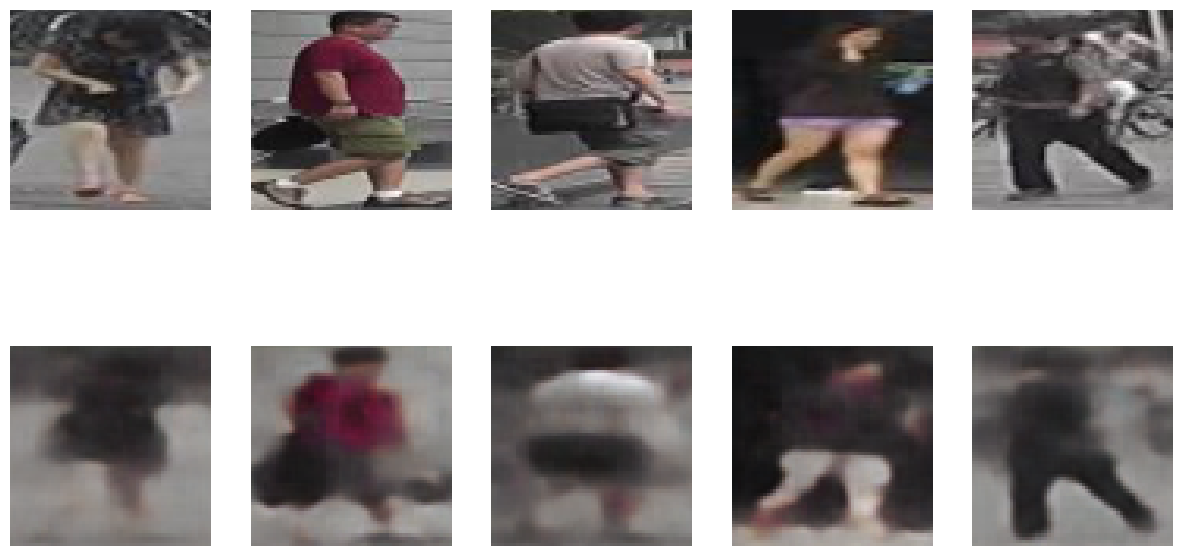

In [ ]:
# Test reconstruction

x_test=[]
for i in range(len(imagePathsTest)):
  image=plt.imread(imagePaths[i])
  image=cv2.resize(image, (64, 64))
  image = image/255
  x_test.append(image)
x_test=np.array(x_test)

reconstructed_img = autoencoder_dr(x_test[0:5])

f, axs = plt.subplots(2, 5, figsize=(15, 8))
for j in range(5):
    axs[0, j].imshow(x_test[j], cmap='binary')
    axs[1, j].imshow(reconstructed_img[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

In [ ]:
# Save model

autoencoder_dr.save("autoencoder_v5.h5")

In [ ]:
encoder.save("encoder_v5.h5")
decoder.save("decoder_v5.h5")

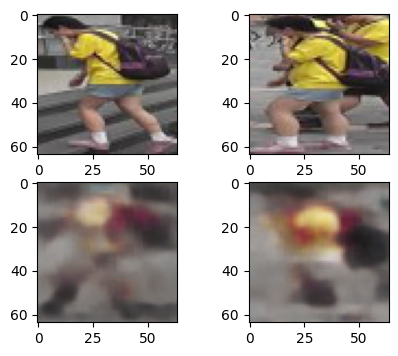

In [ ]:
# Analysis on similar images

imagePathsCompare = ['dataset/192.jpg', 'dataset/221.jpg']

x_compare=[]
for i in range(len(imagePathsCompare)):
  image=plt.imread(imagePathsCompare[i])
  image=cv2.resize(image, (64, 64))
  image = image/255
  x_compare.append(image)
x_compare=np.array(x_compare)

reconstructed_compare = autoencoder_dr(x_compare)

f, axs = plt.subplots(2, 2, figsize=(5, 4))
for j in range(2):
    axs[0,j].imshow(x_compare[j], cmap='binary')
    axs[1,j].imshow(reconstructed_compare[j].numpy().squeeze(), cmap='binary')

In [ ]:
x_compare_feature = encoder(x_compare)
x_compare_feature

<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[33.08203  , 27.600775 , 32.648605 , 15.88756  , 30.230091 ,
        17.756414 , 20.449913 , 25.74517  , 28.674772 , 33.882175 ,
        20.976784 , 42.488125 , 15.798284 , 28.313873 , 30.486624 ,
        18.257477 ,  3.5933542, 20.503206 , 32.677658 , 28.495724 ,
        20.669897 , 32.441093 , 36.543877 , 36.805794 , 26.921986 ,
         9.754002 , 12.945311 , 30.390314 , 35.318657 , 24.860231 ,
        26.684265 , 33.262966 ],
       [24.180376 , 41.352646 , 30.733238 , 22.733517 , 27.779503 ,
         9.531252 , 12.411281 , 48.005592 , 22.009972 , 39.34196  ,
        13.733697 , 23.090405 , 26.483795 , 21.326275 , 31.877724 ,
         9.763715 , 17.419806 , 21.976933 , 15.911828 , 26.78307  ,
        23.48771  , 26.949545 , 16.572706 , 36.270683 , 24.873251 ,
        16.954985 , 12.326858 , 28.323643 , 25.99118  , 34.54882  ,
        39.63762  , 33.47109  ]], dtype=float32)>

In [ ]:
# Euclidean distance between similar images

dist = np.linalg.norm(np.ndarray.flatten(x_compare[0]) - np.ndarray.flatten(x_compare[1]))
dist_feature = np.linalg.norm(np.ndarray.flatten(x_compare_feature[0].numpy())-  np.ndarray.flatten(x_compare_feature[1].numpy()))
dist, dist_feature

(26.220671501596165, 54.924957)

In [ ]:
# MSE distance between similar images

from sklearn.metrics import mean_squared_error

dist_mse = mean_squared_error(np.ndarray.flatten(x_compare[0]), np.ndarray.flatten(x_compare[1]))
dist_feature_mse = mean_squared_error(np.ndarray.flatten(x_compare_feature[0].numpy()), np.ndarray.flatten(x_compare_feature[1].numpy()))
dist_mse, dist_feature_mse

(0.055950814940968215, 94.27346)

In [ ]:
# Activation map

activations = get_activations(encoder, np.array([x_compare[0]]))

conv2d_6_input (1, 64, 64, 3) 


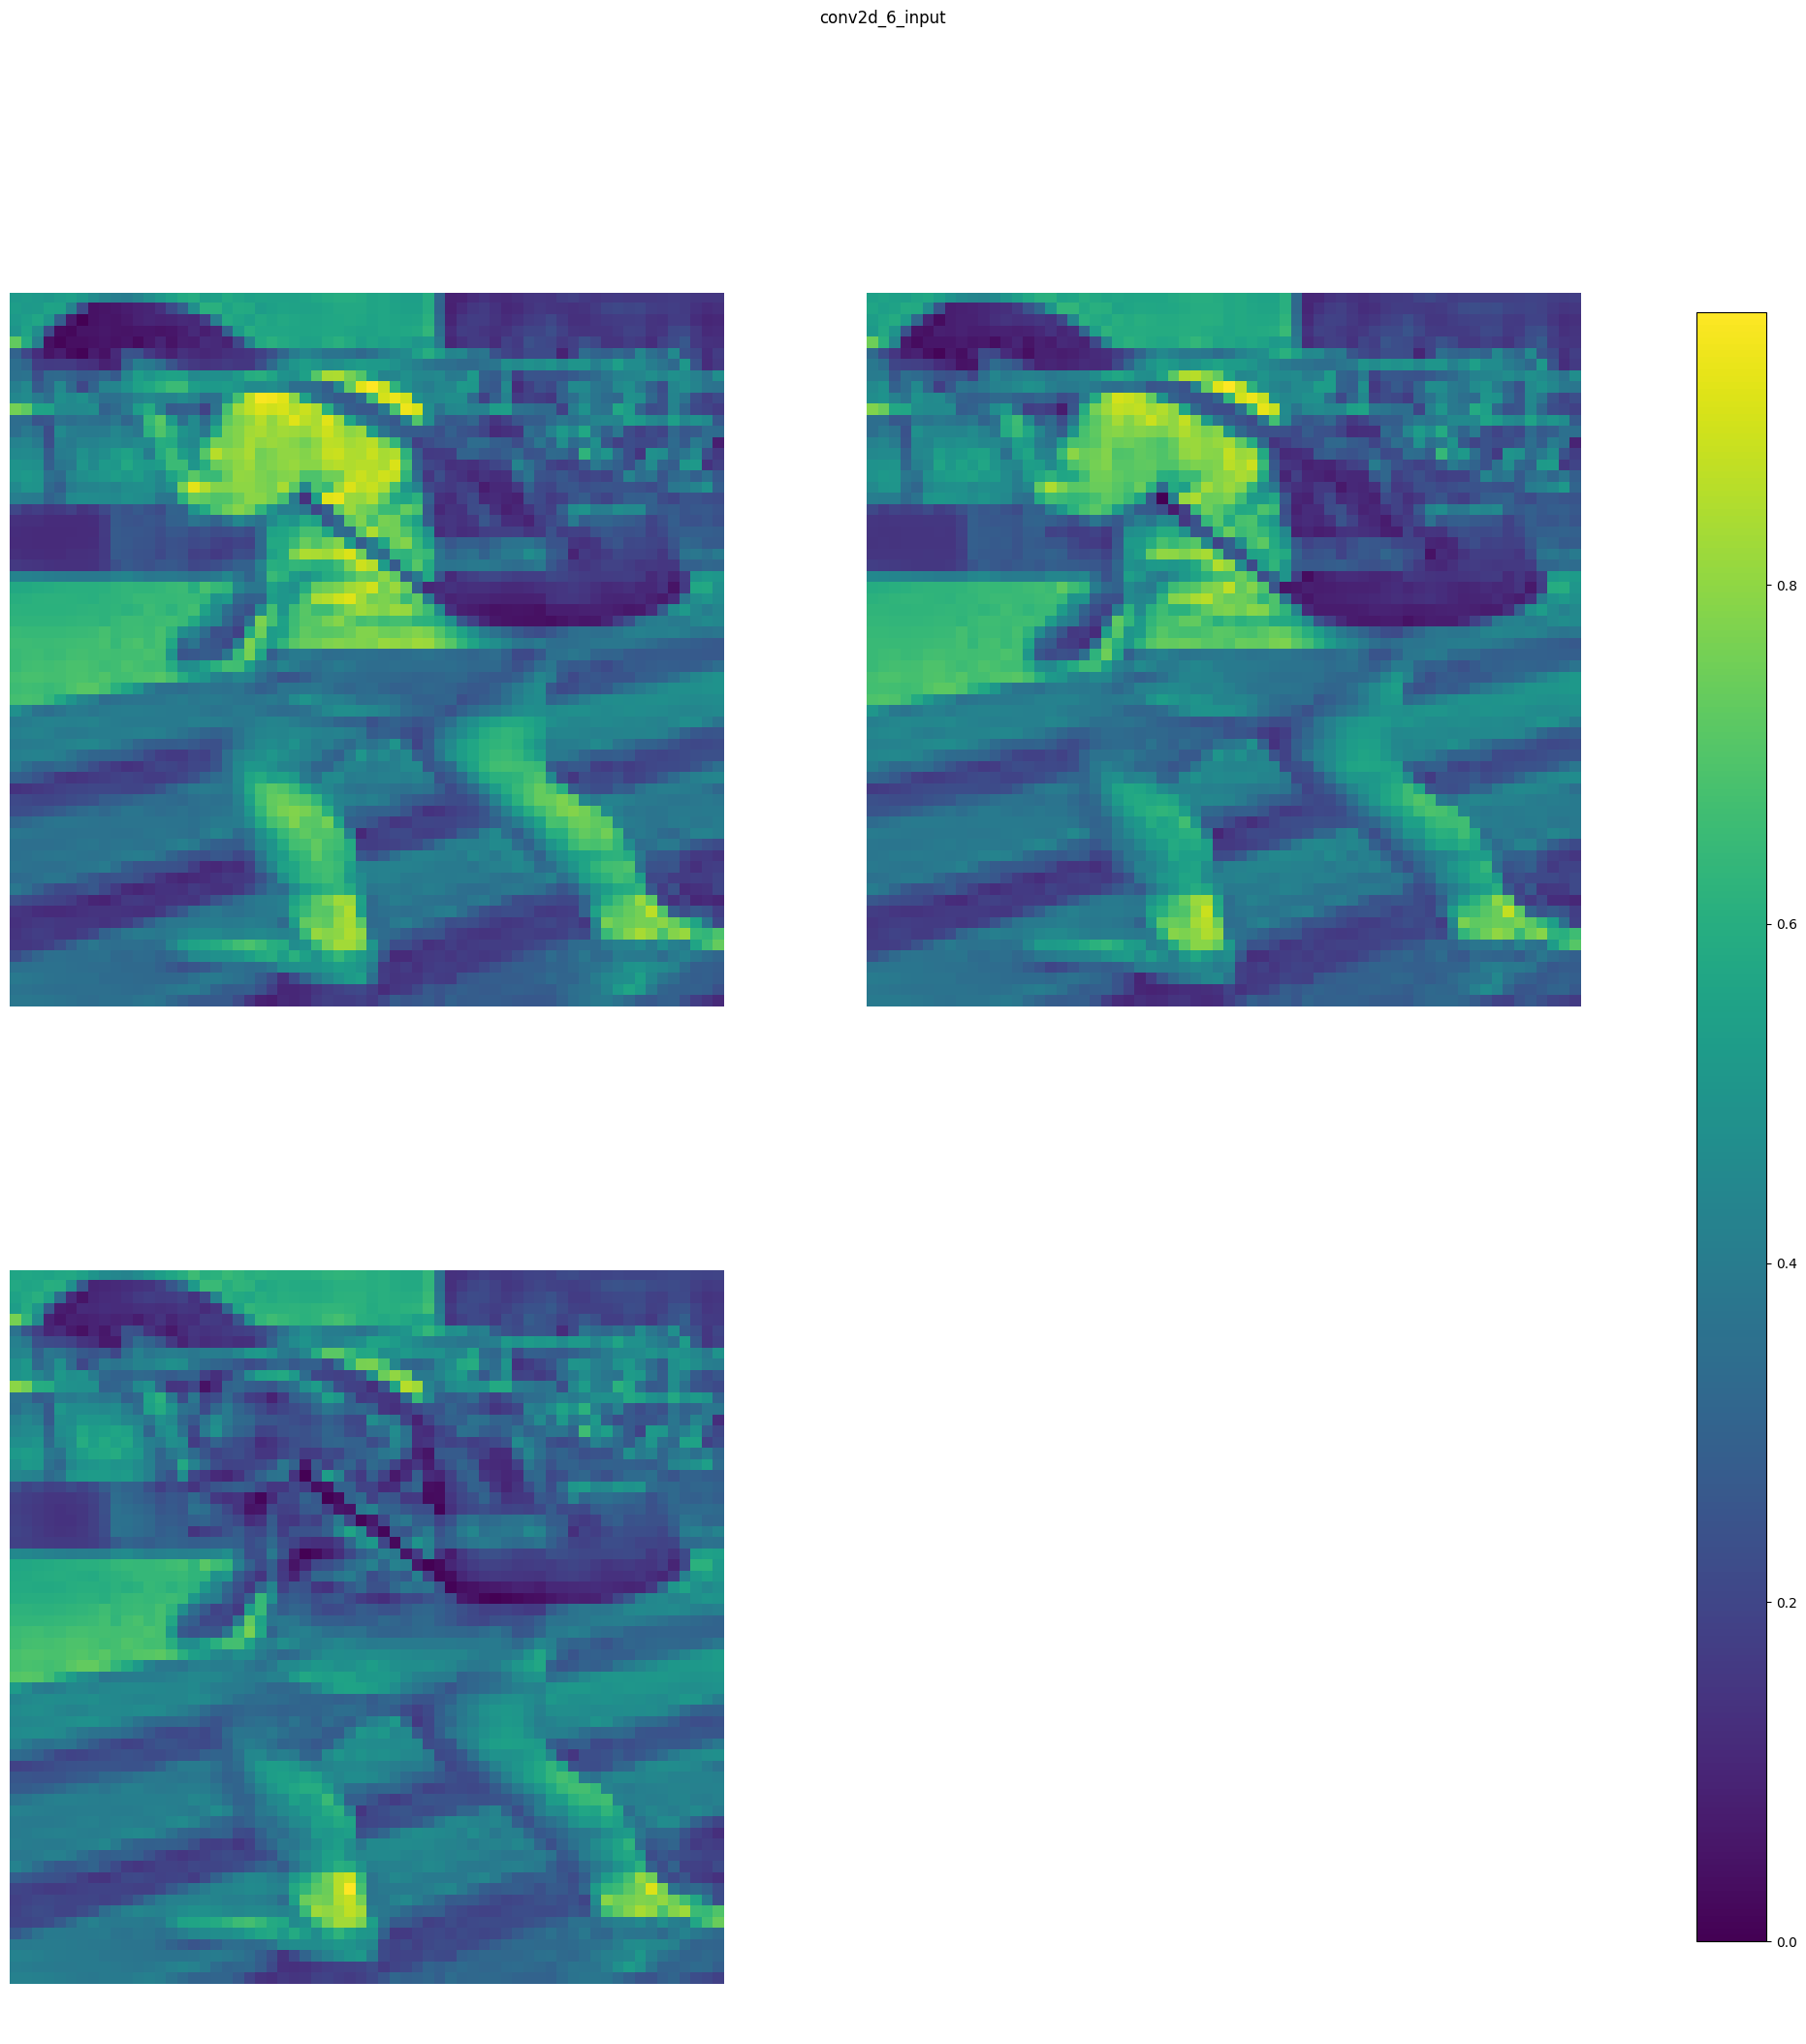

conv2d_6 (1, 64, 64, 64) 


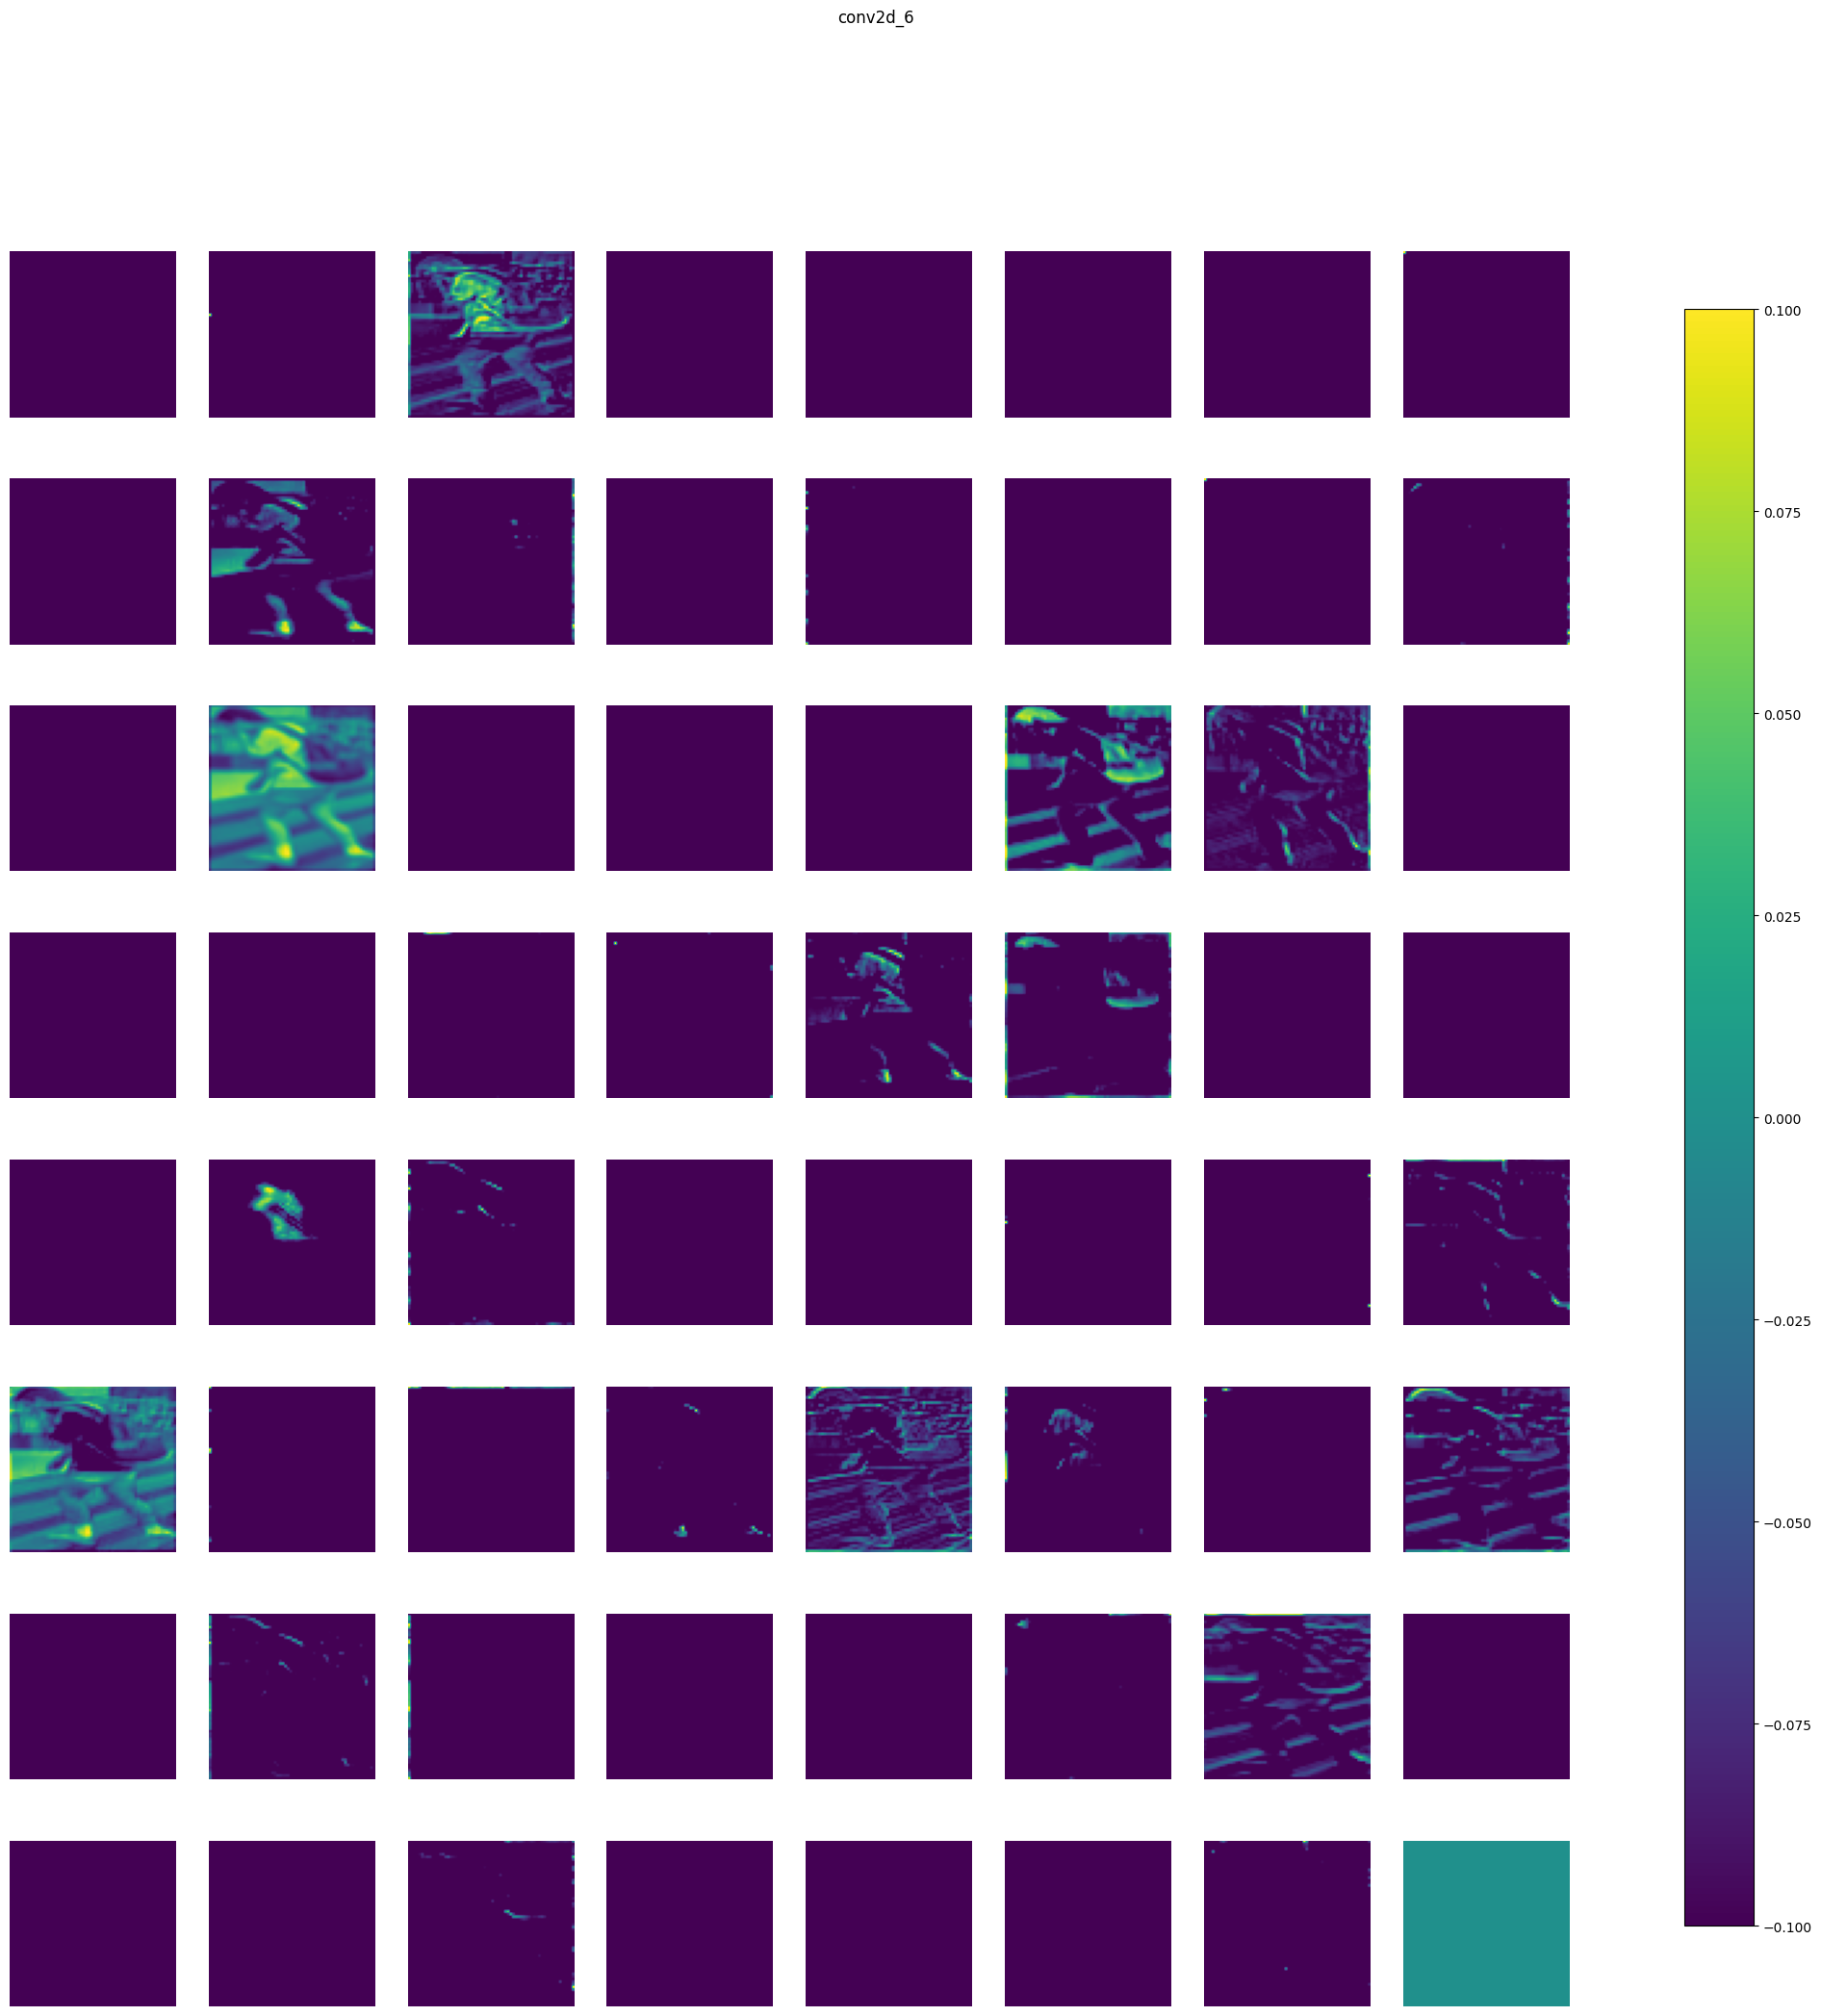

max_pooling2d_2 (1, 32, 32, 64) 


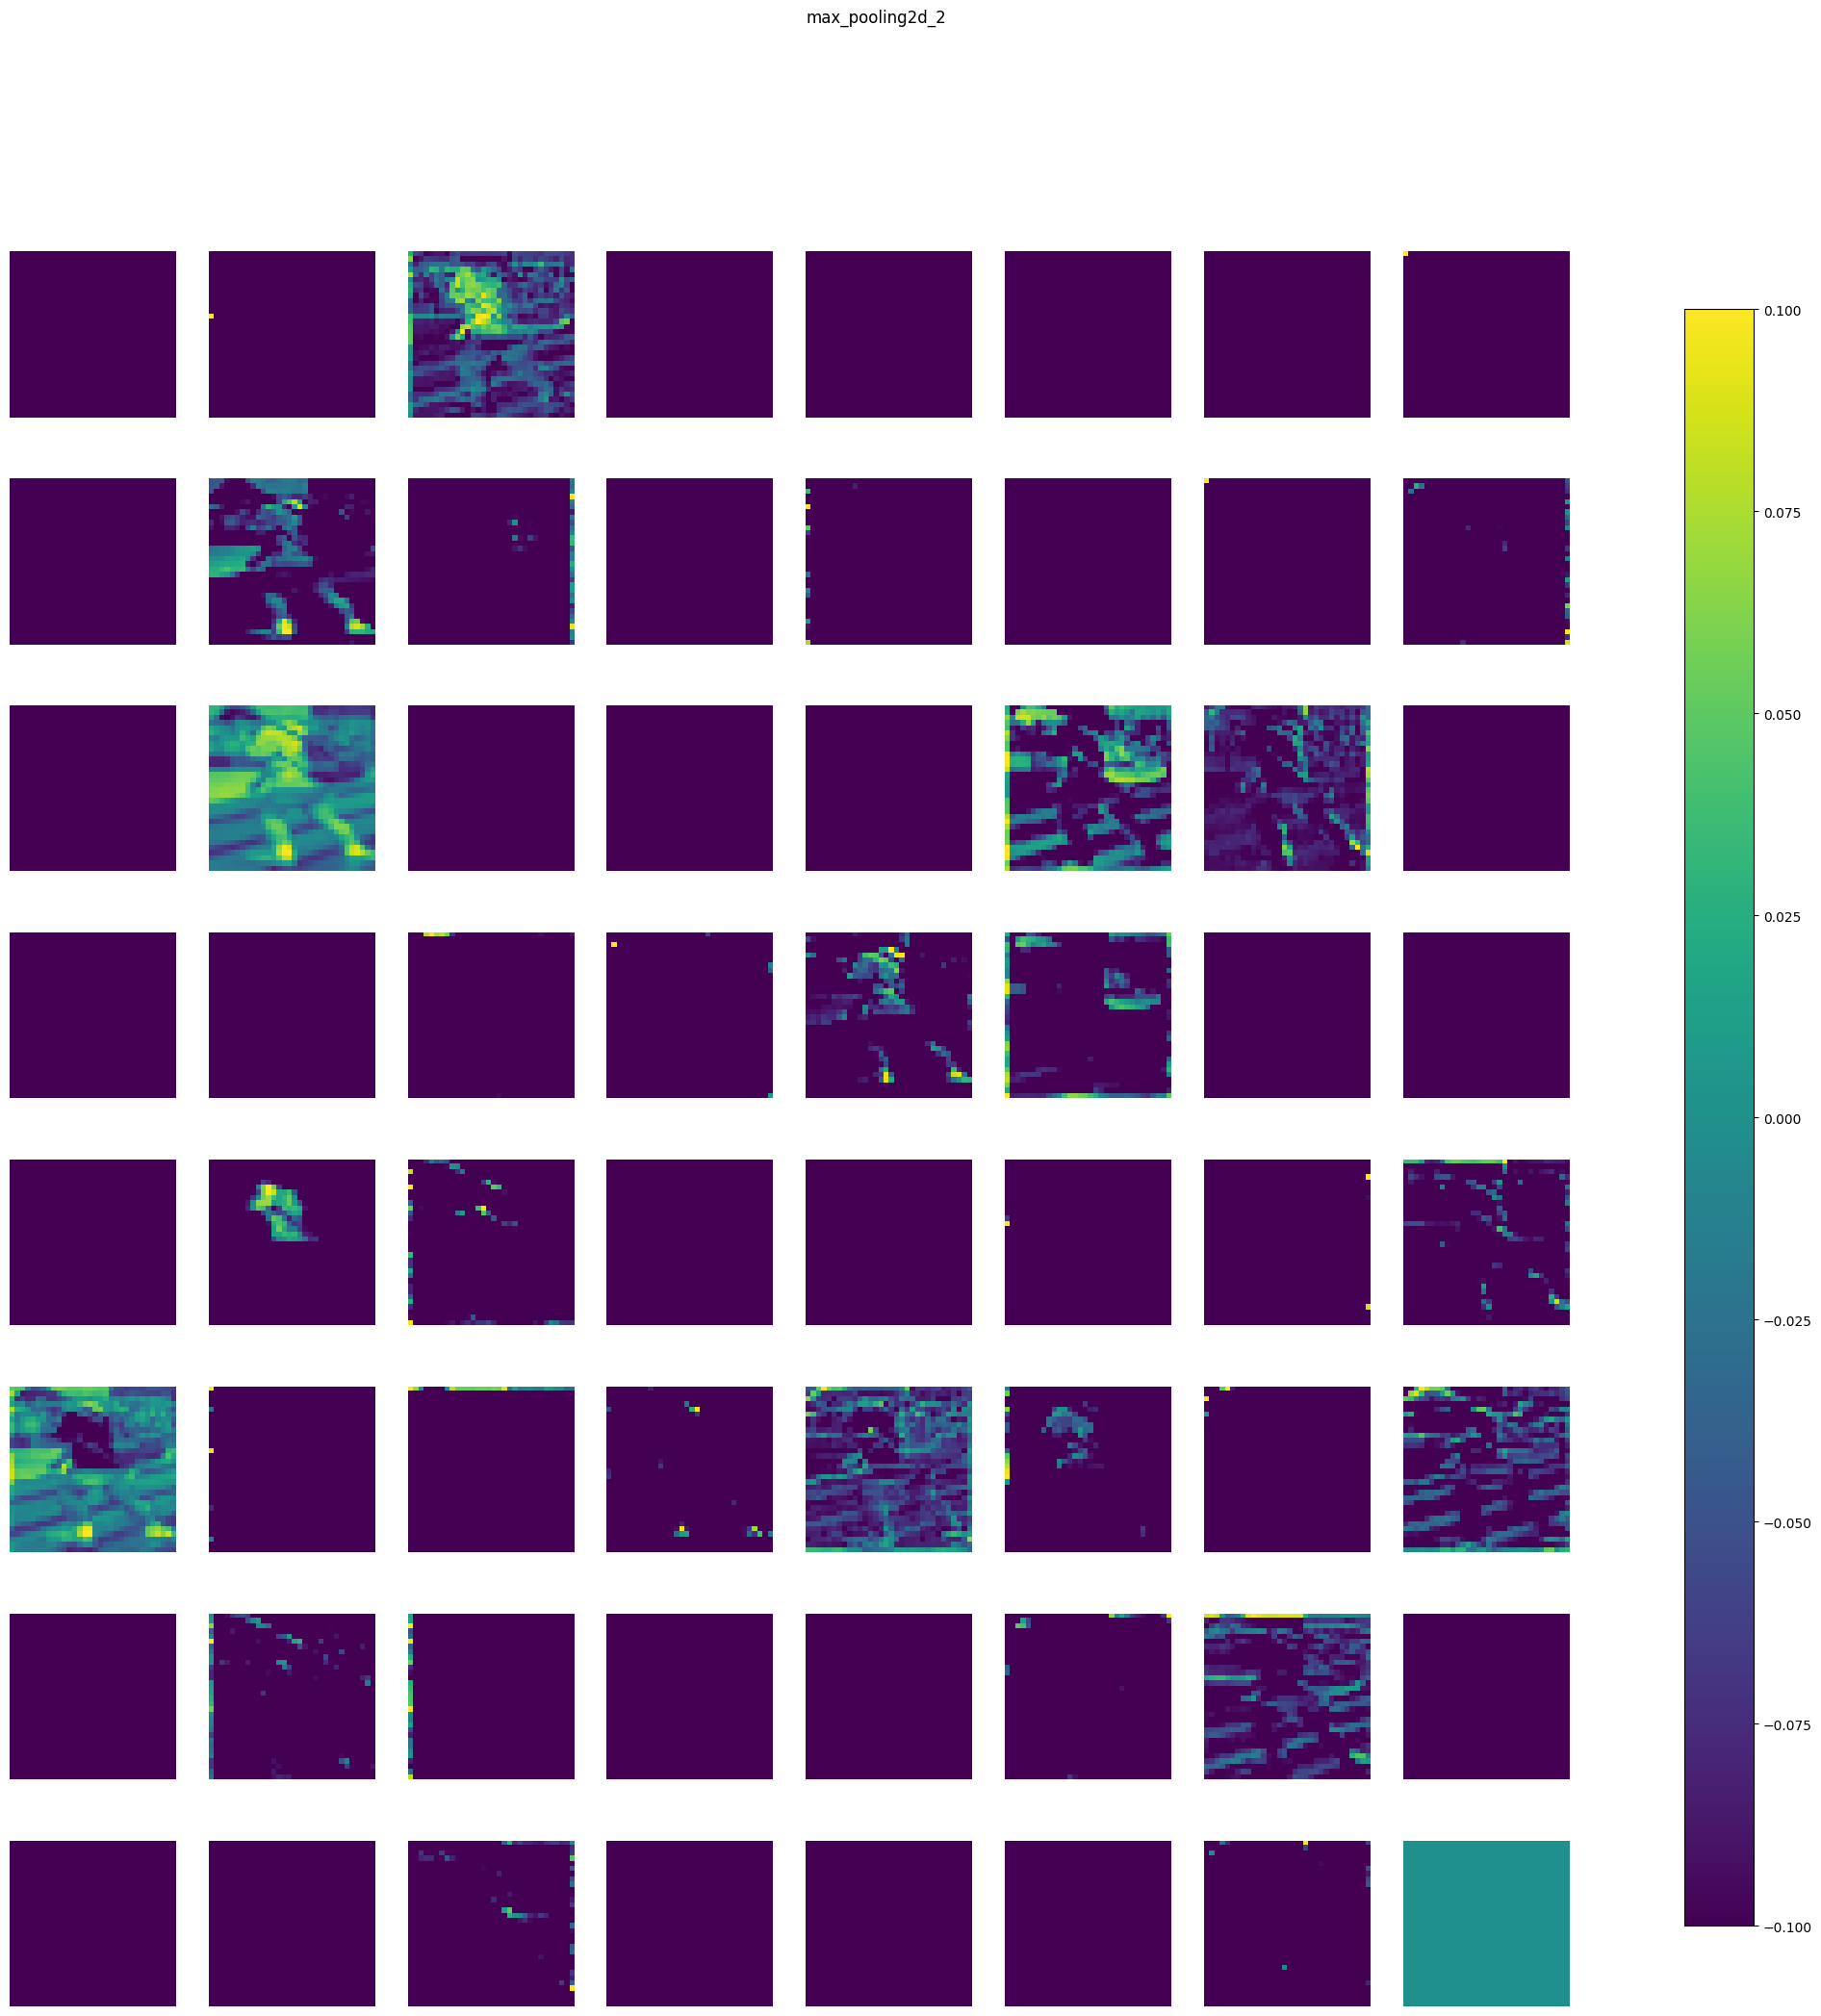

conv2d_7 (1, 32, 32, 32) 


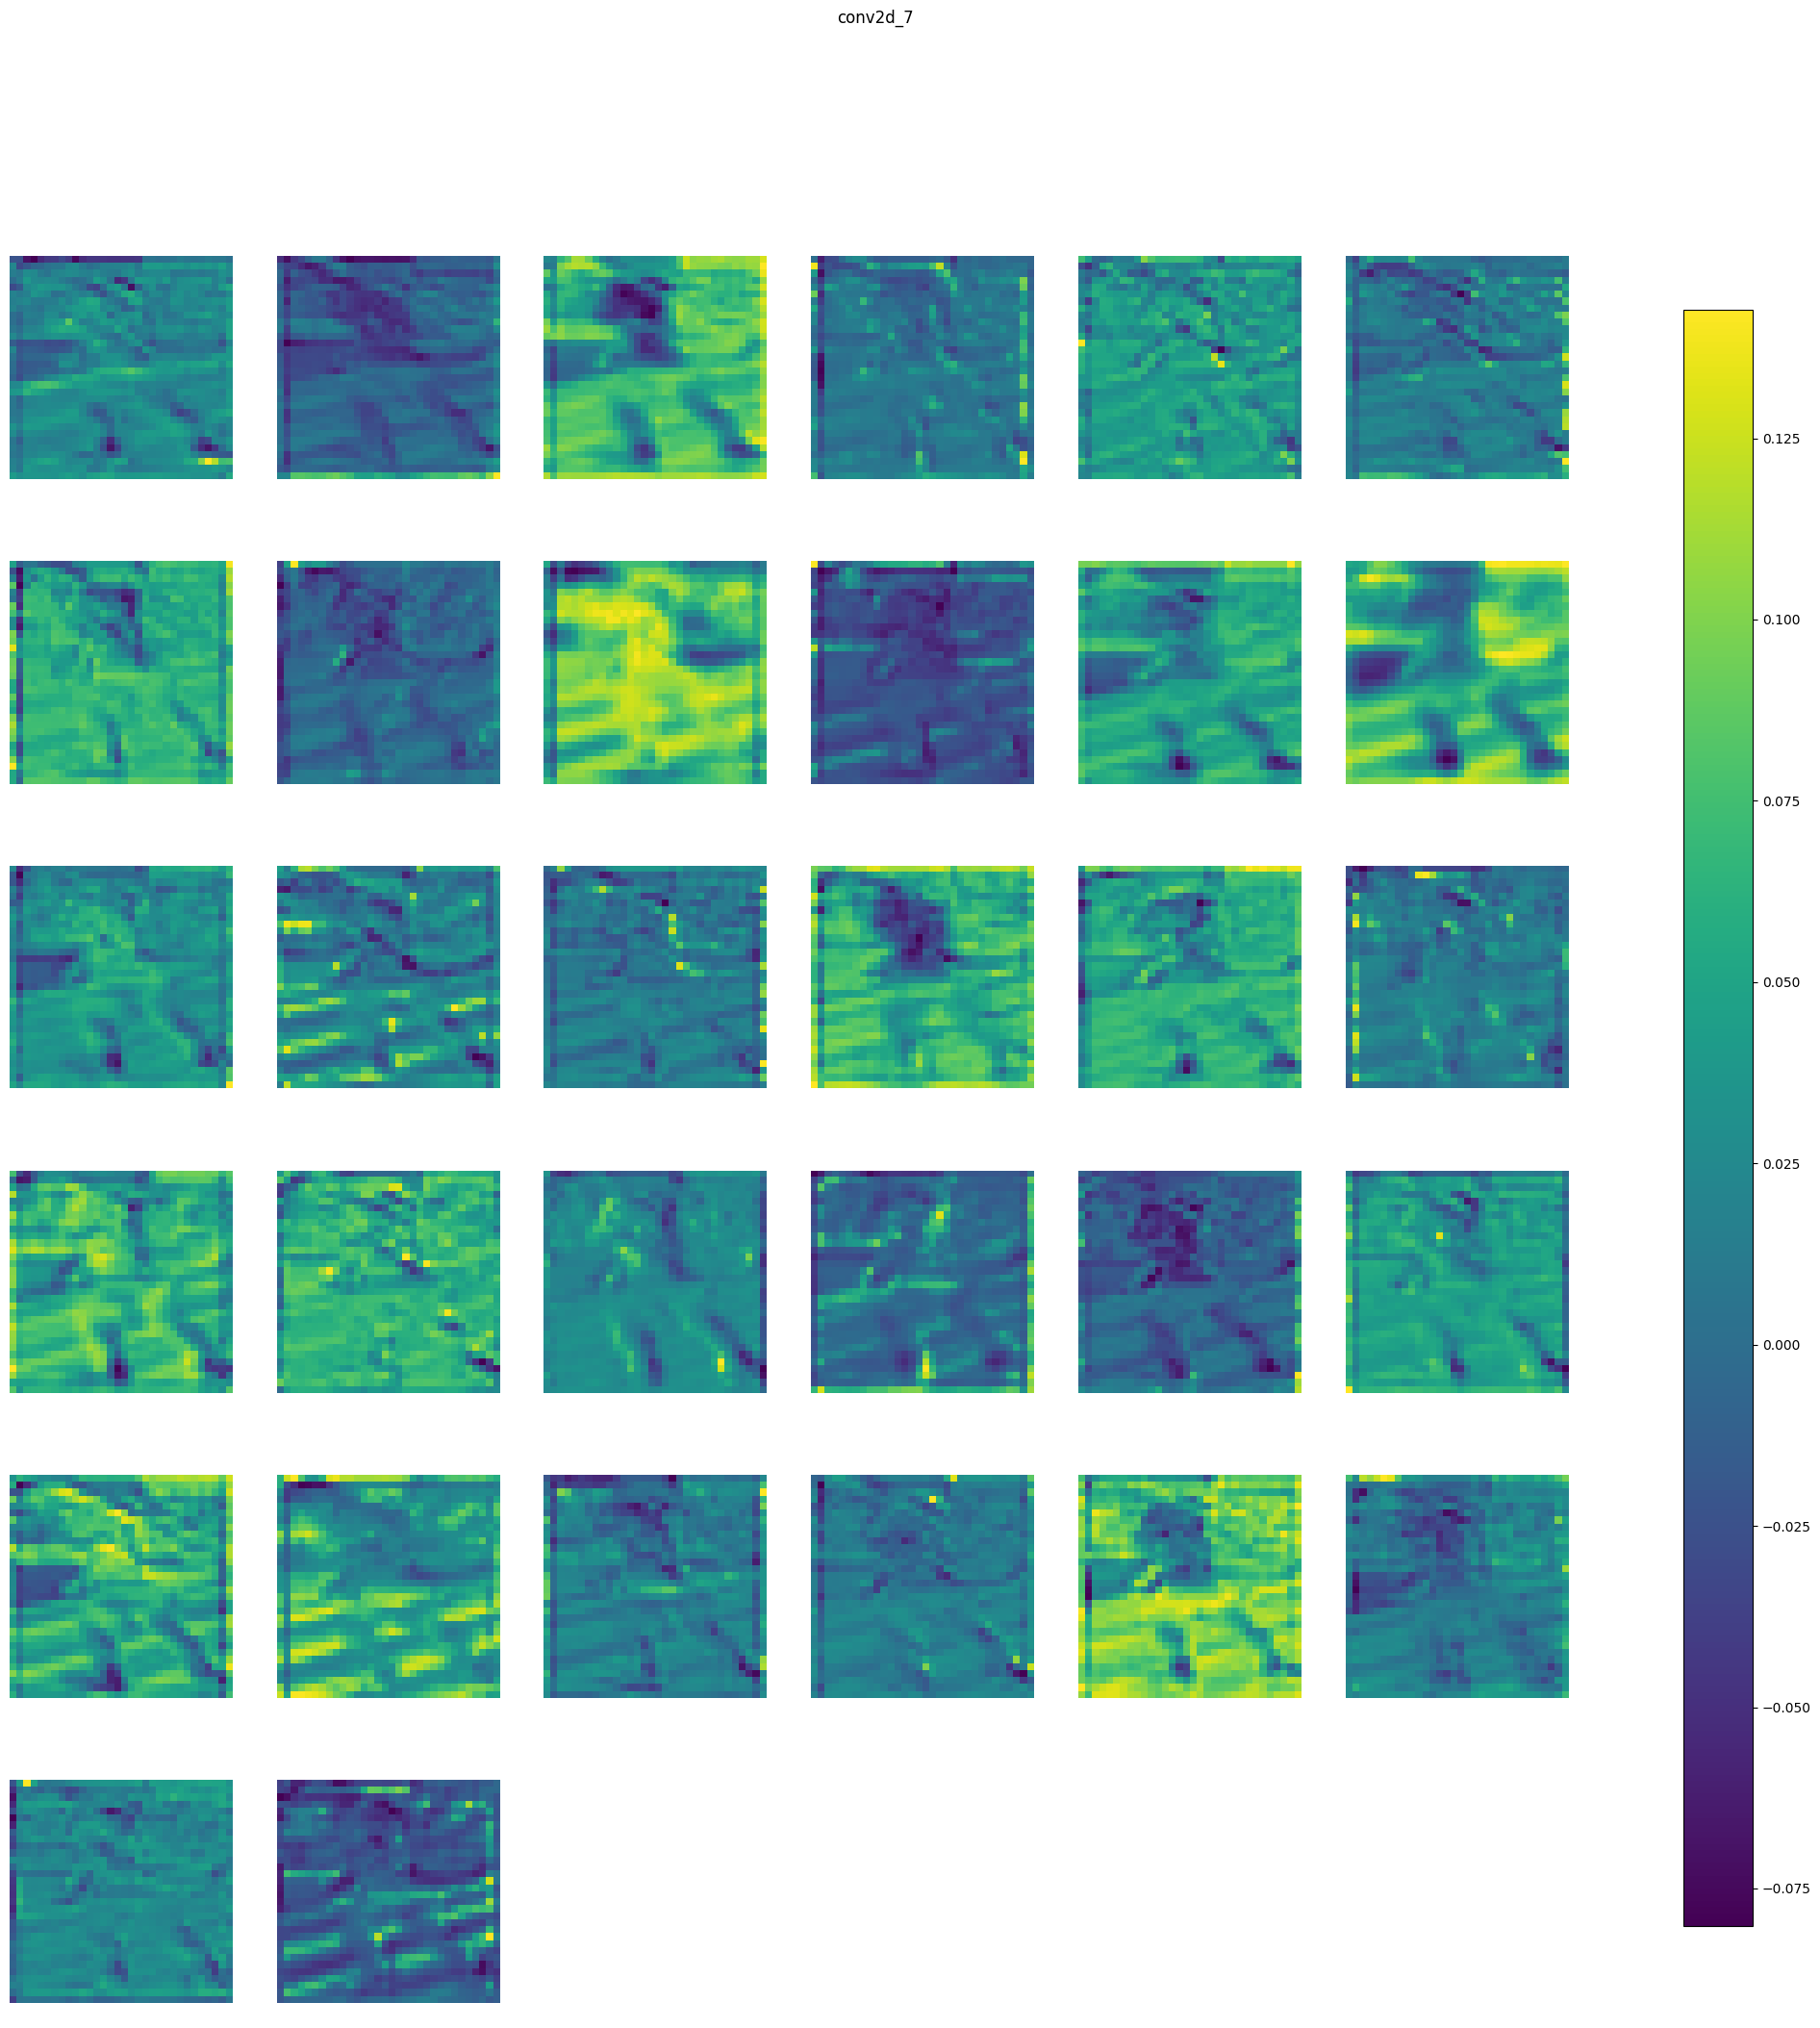

max_pooling2d_3 (1, 16, 16, 32) 


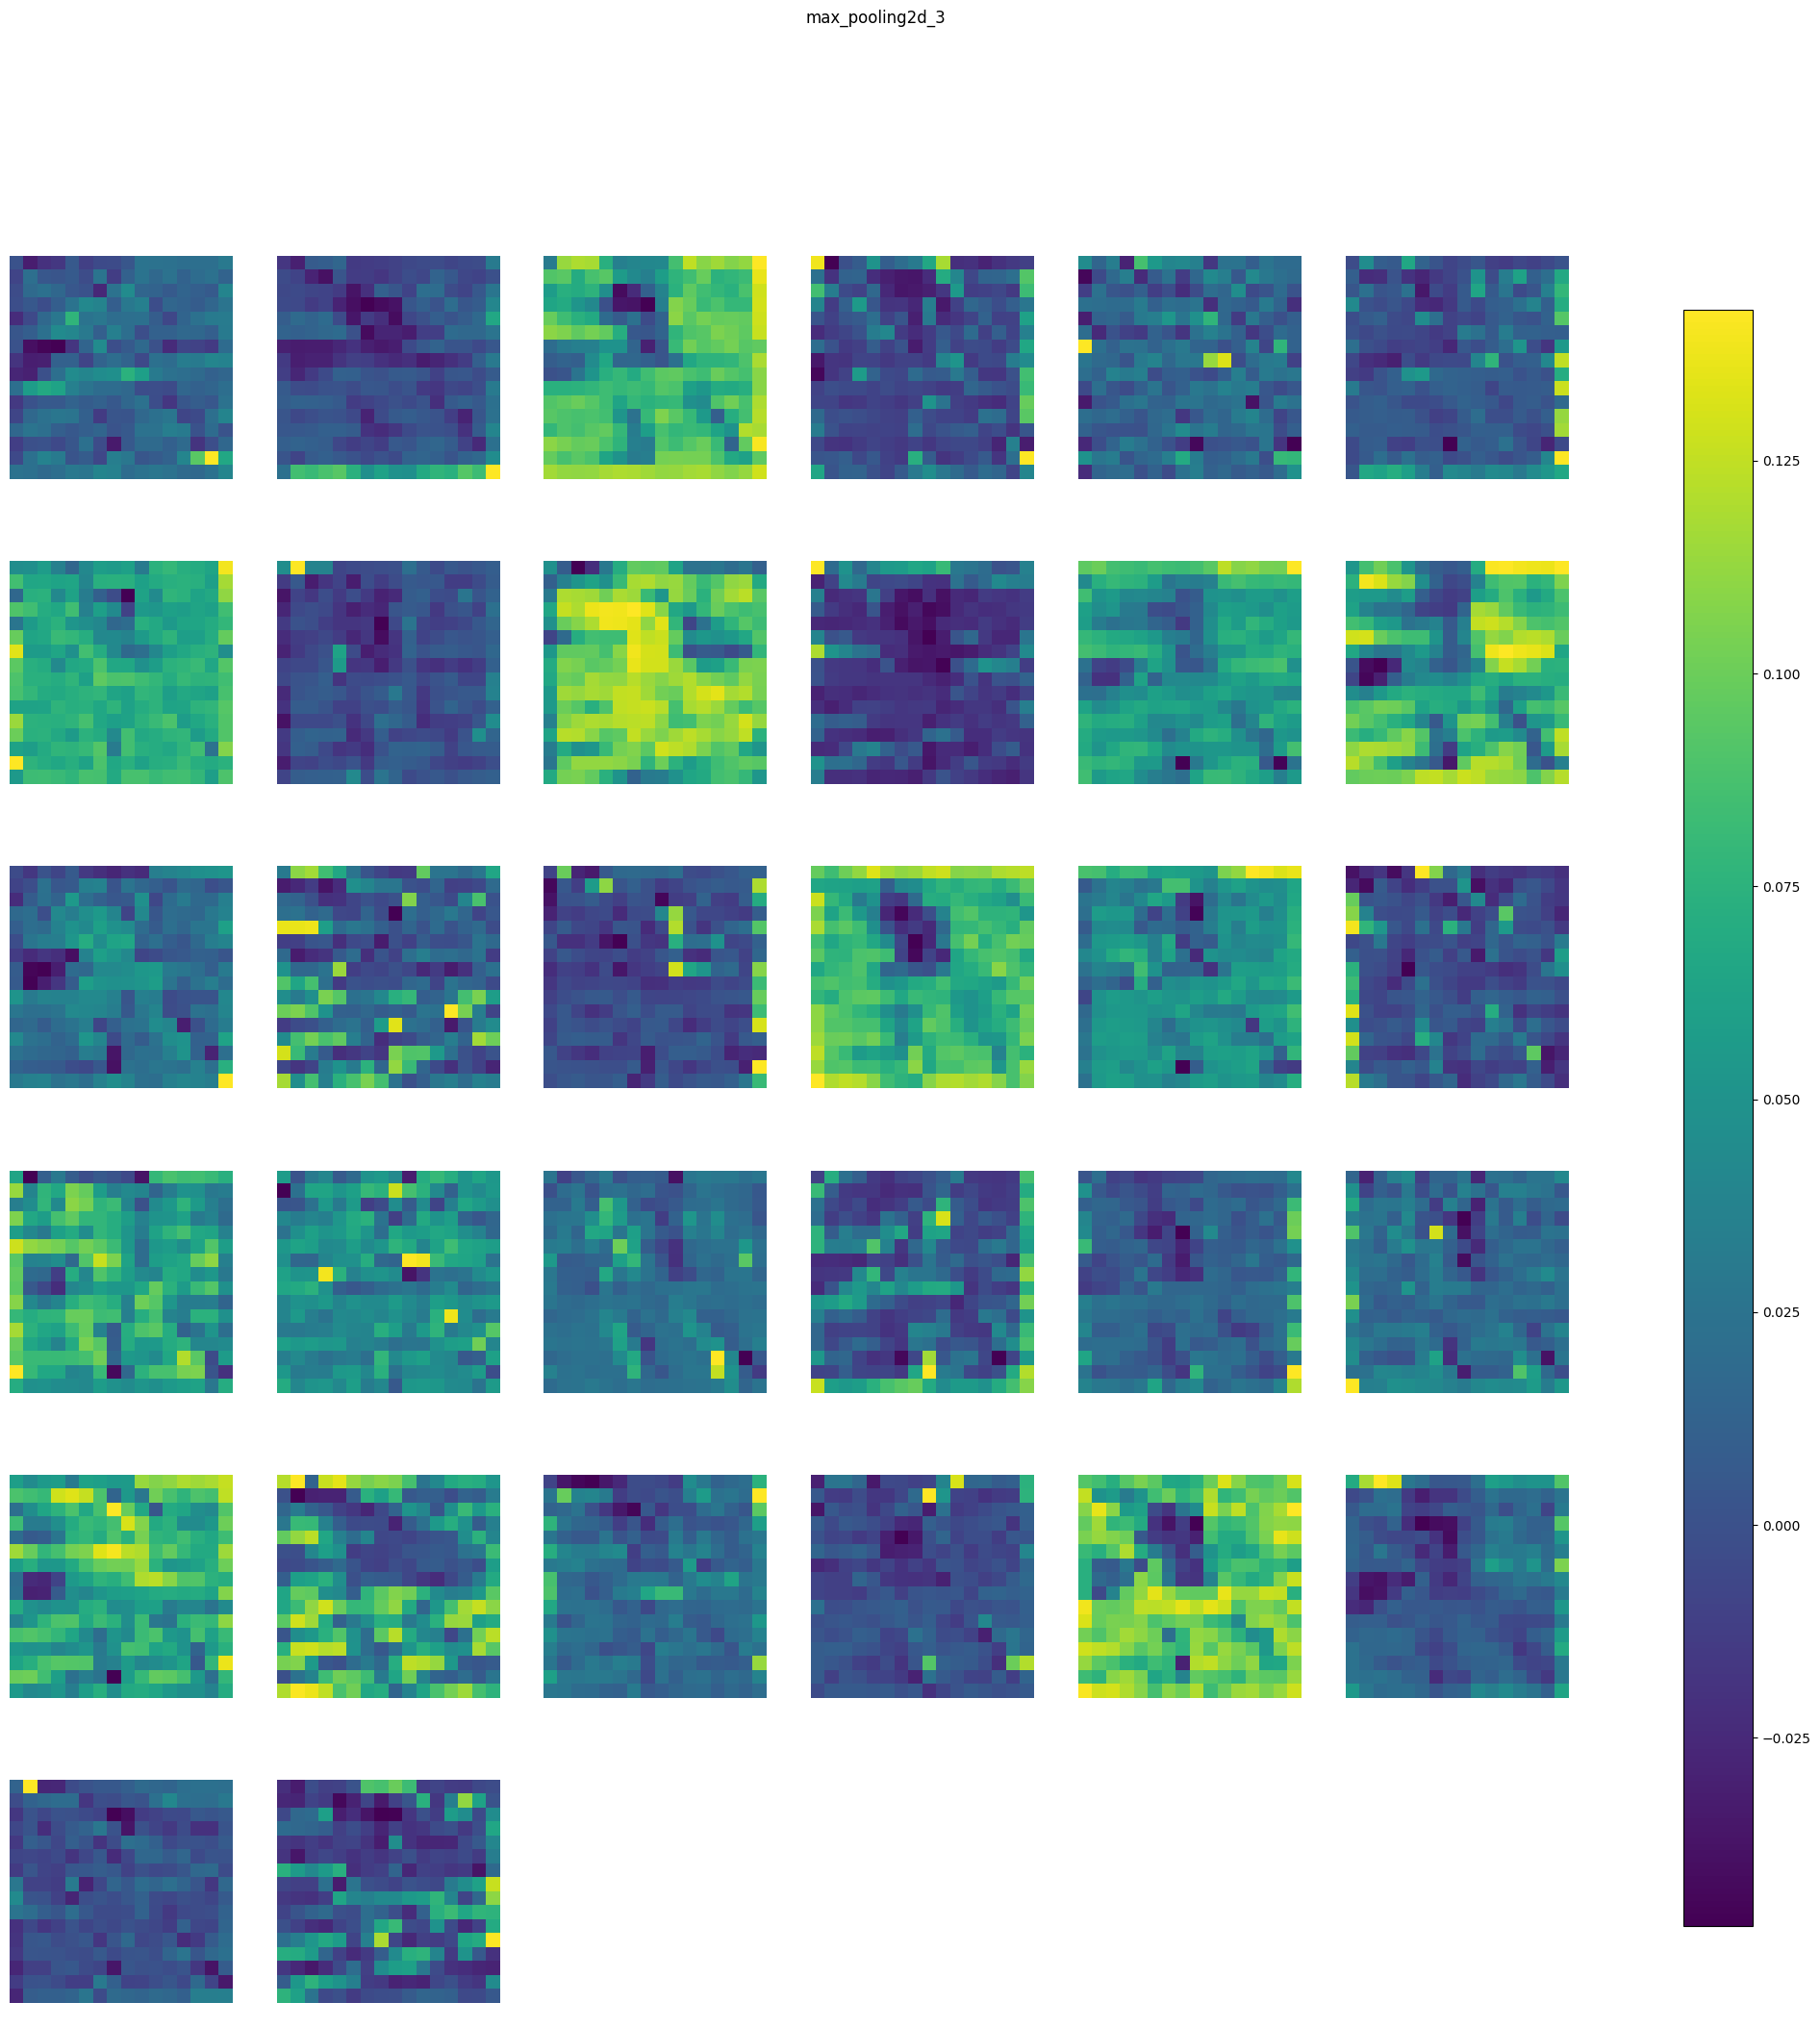

conv2d_8 (1, 16, 16, 16) 


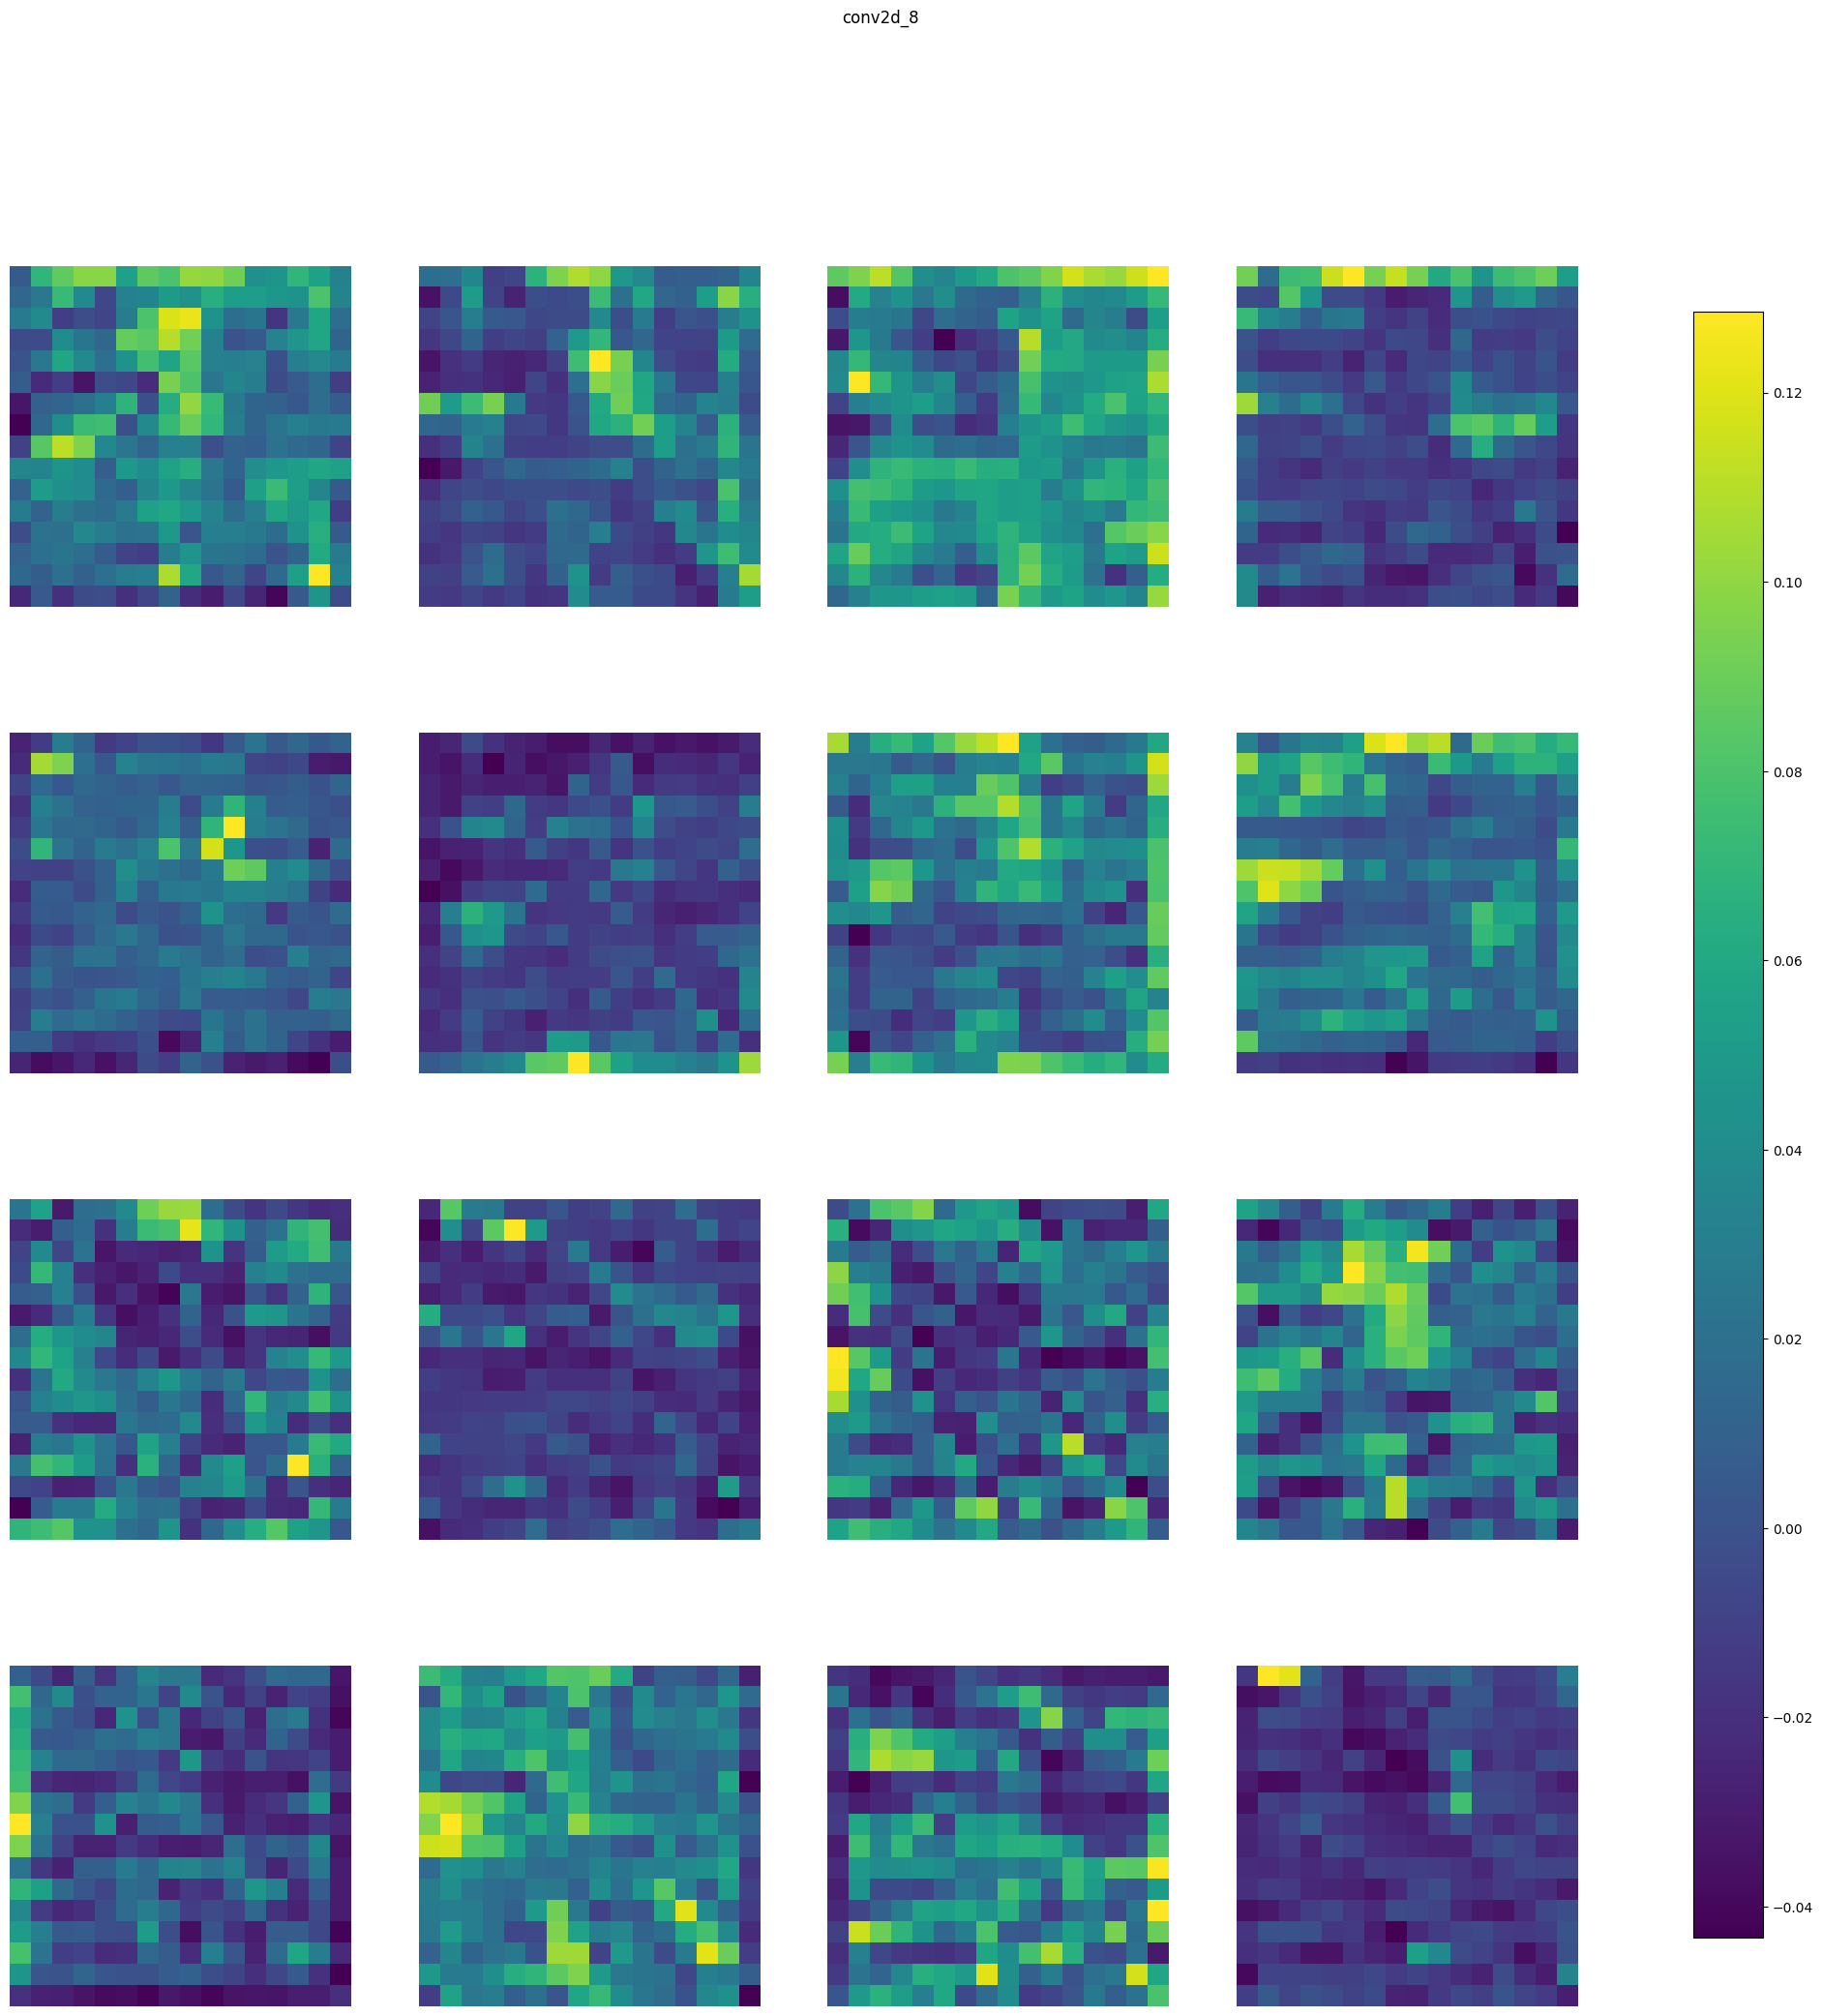

flatten_1 (1, 4096) 


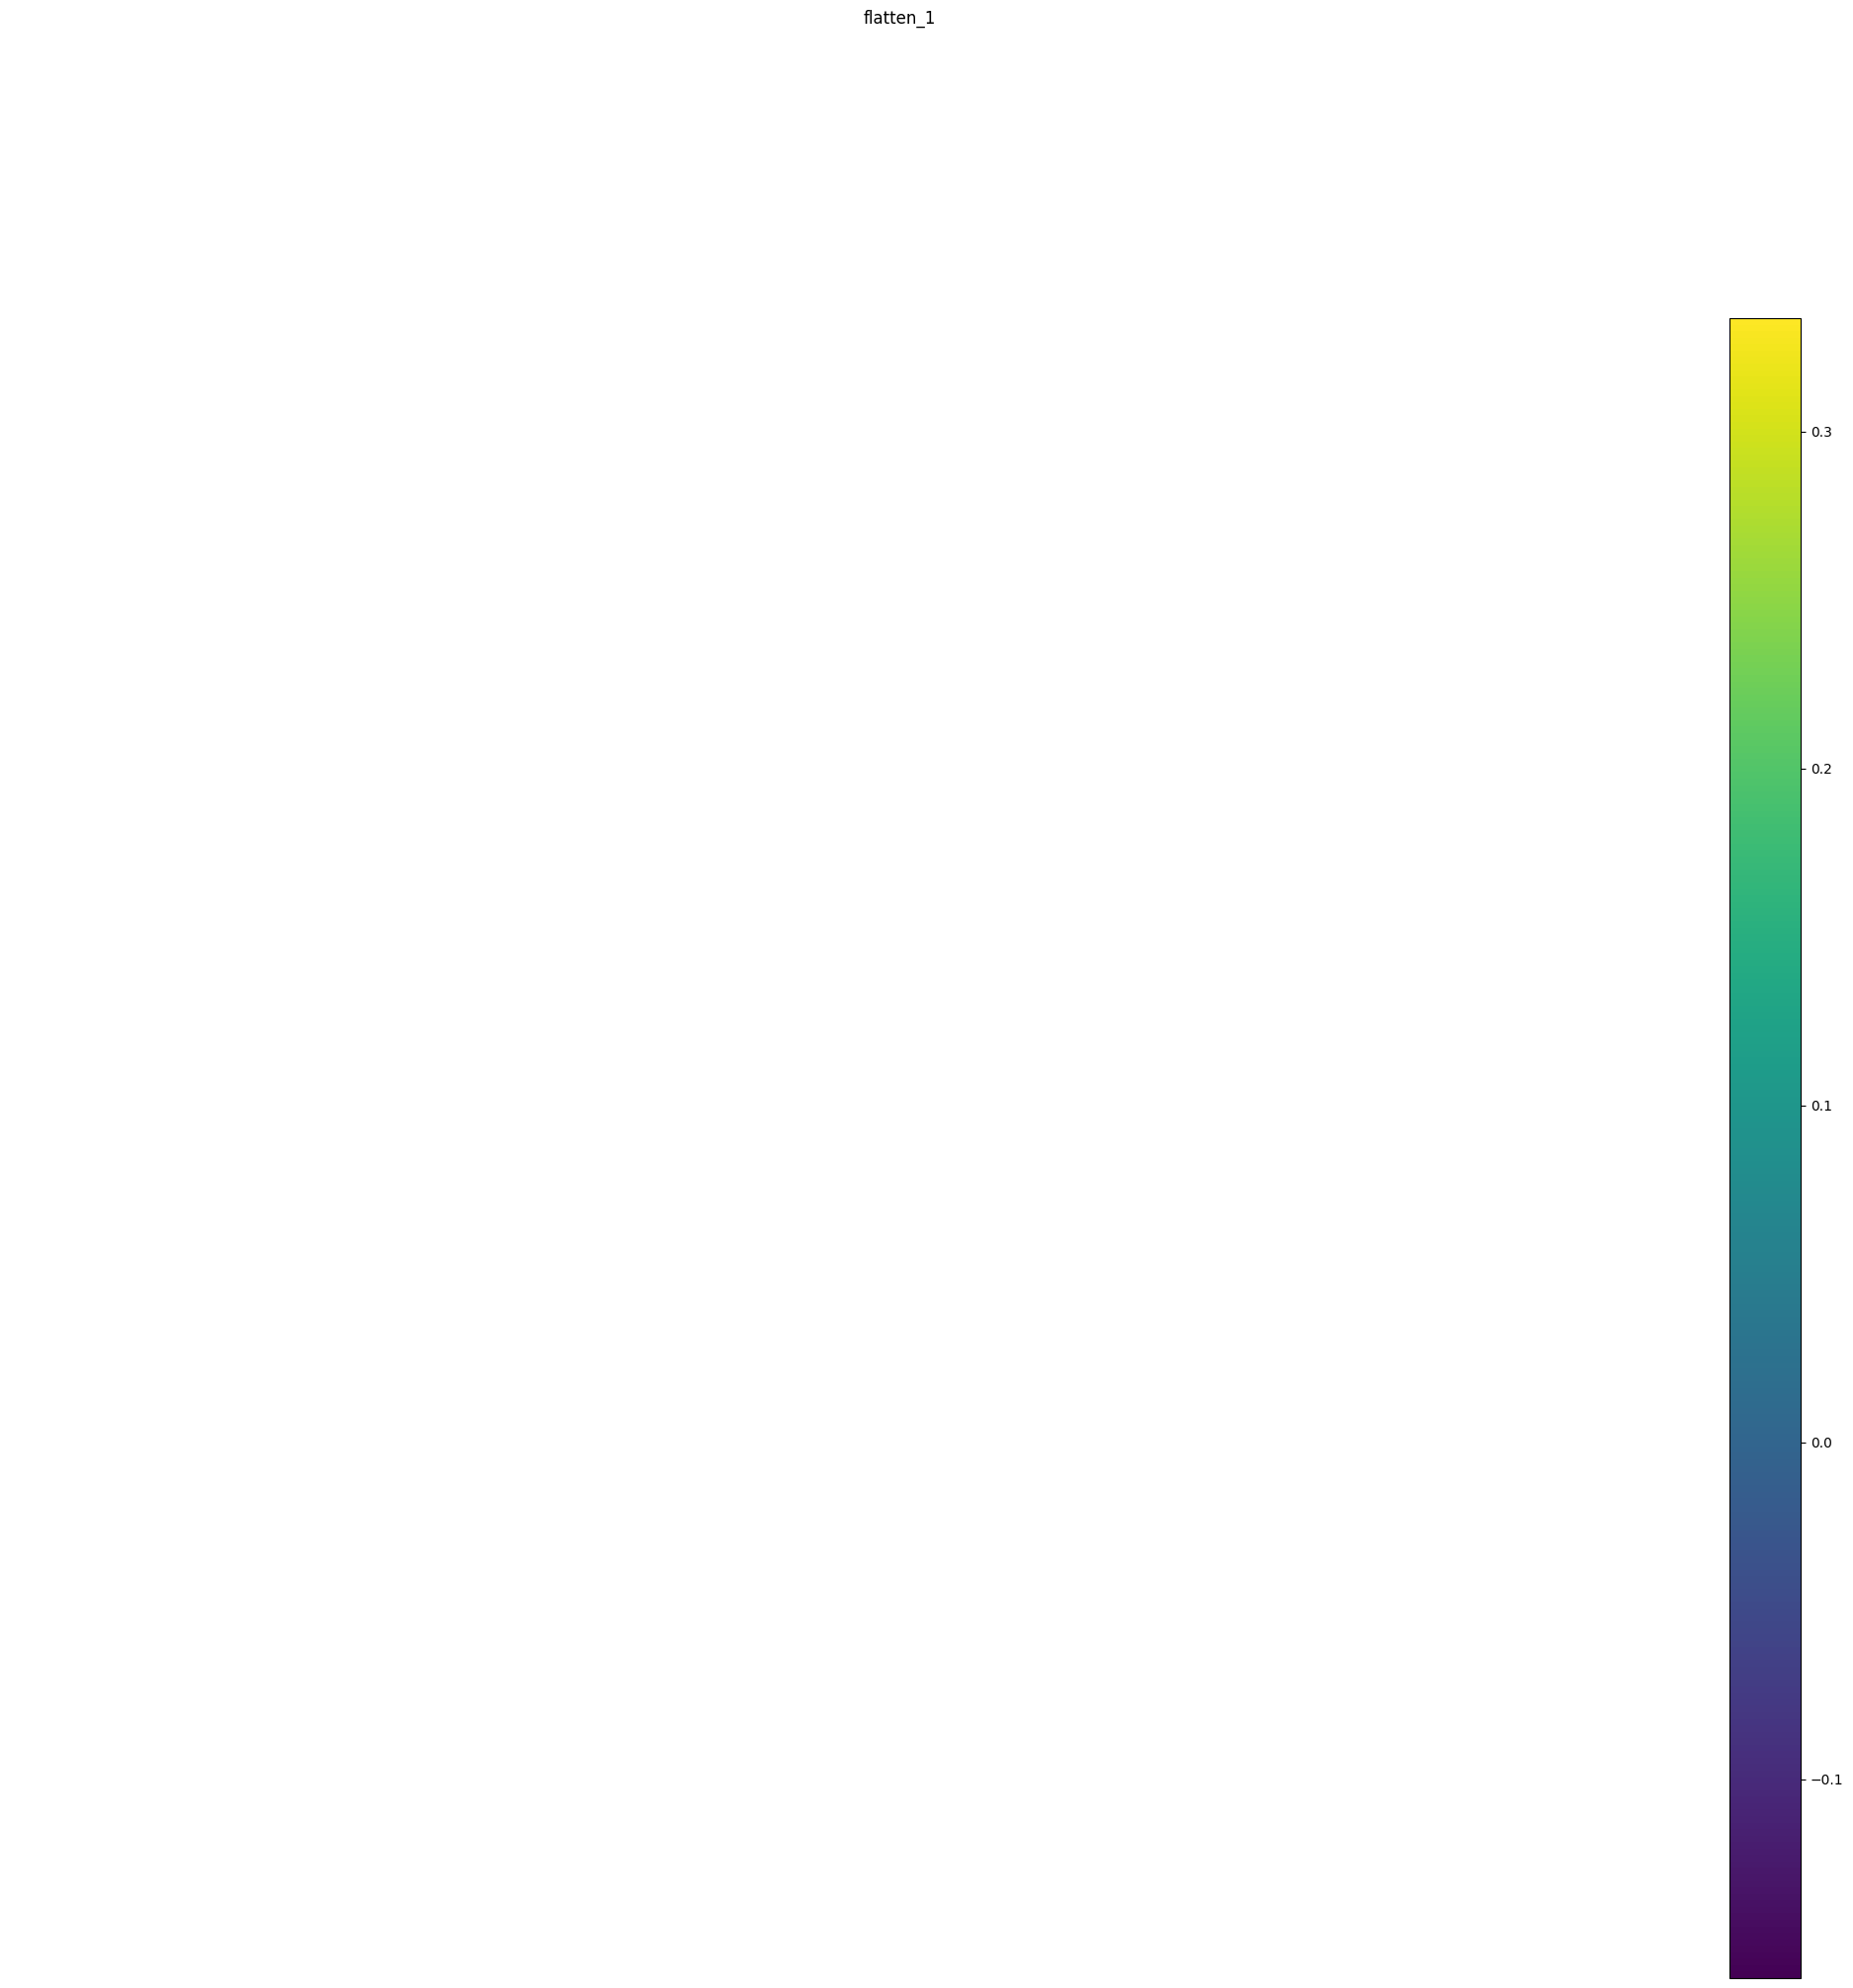

batch_normalization_4 (1, 4096) 


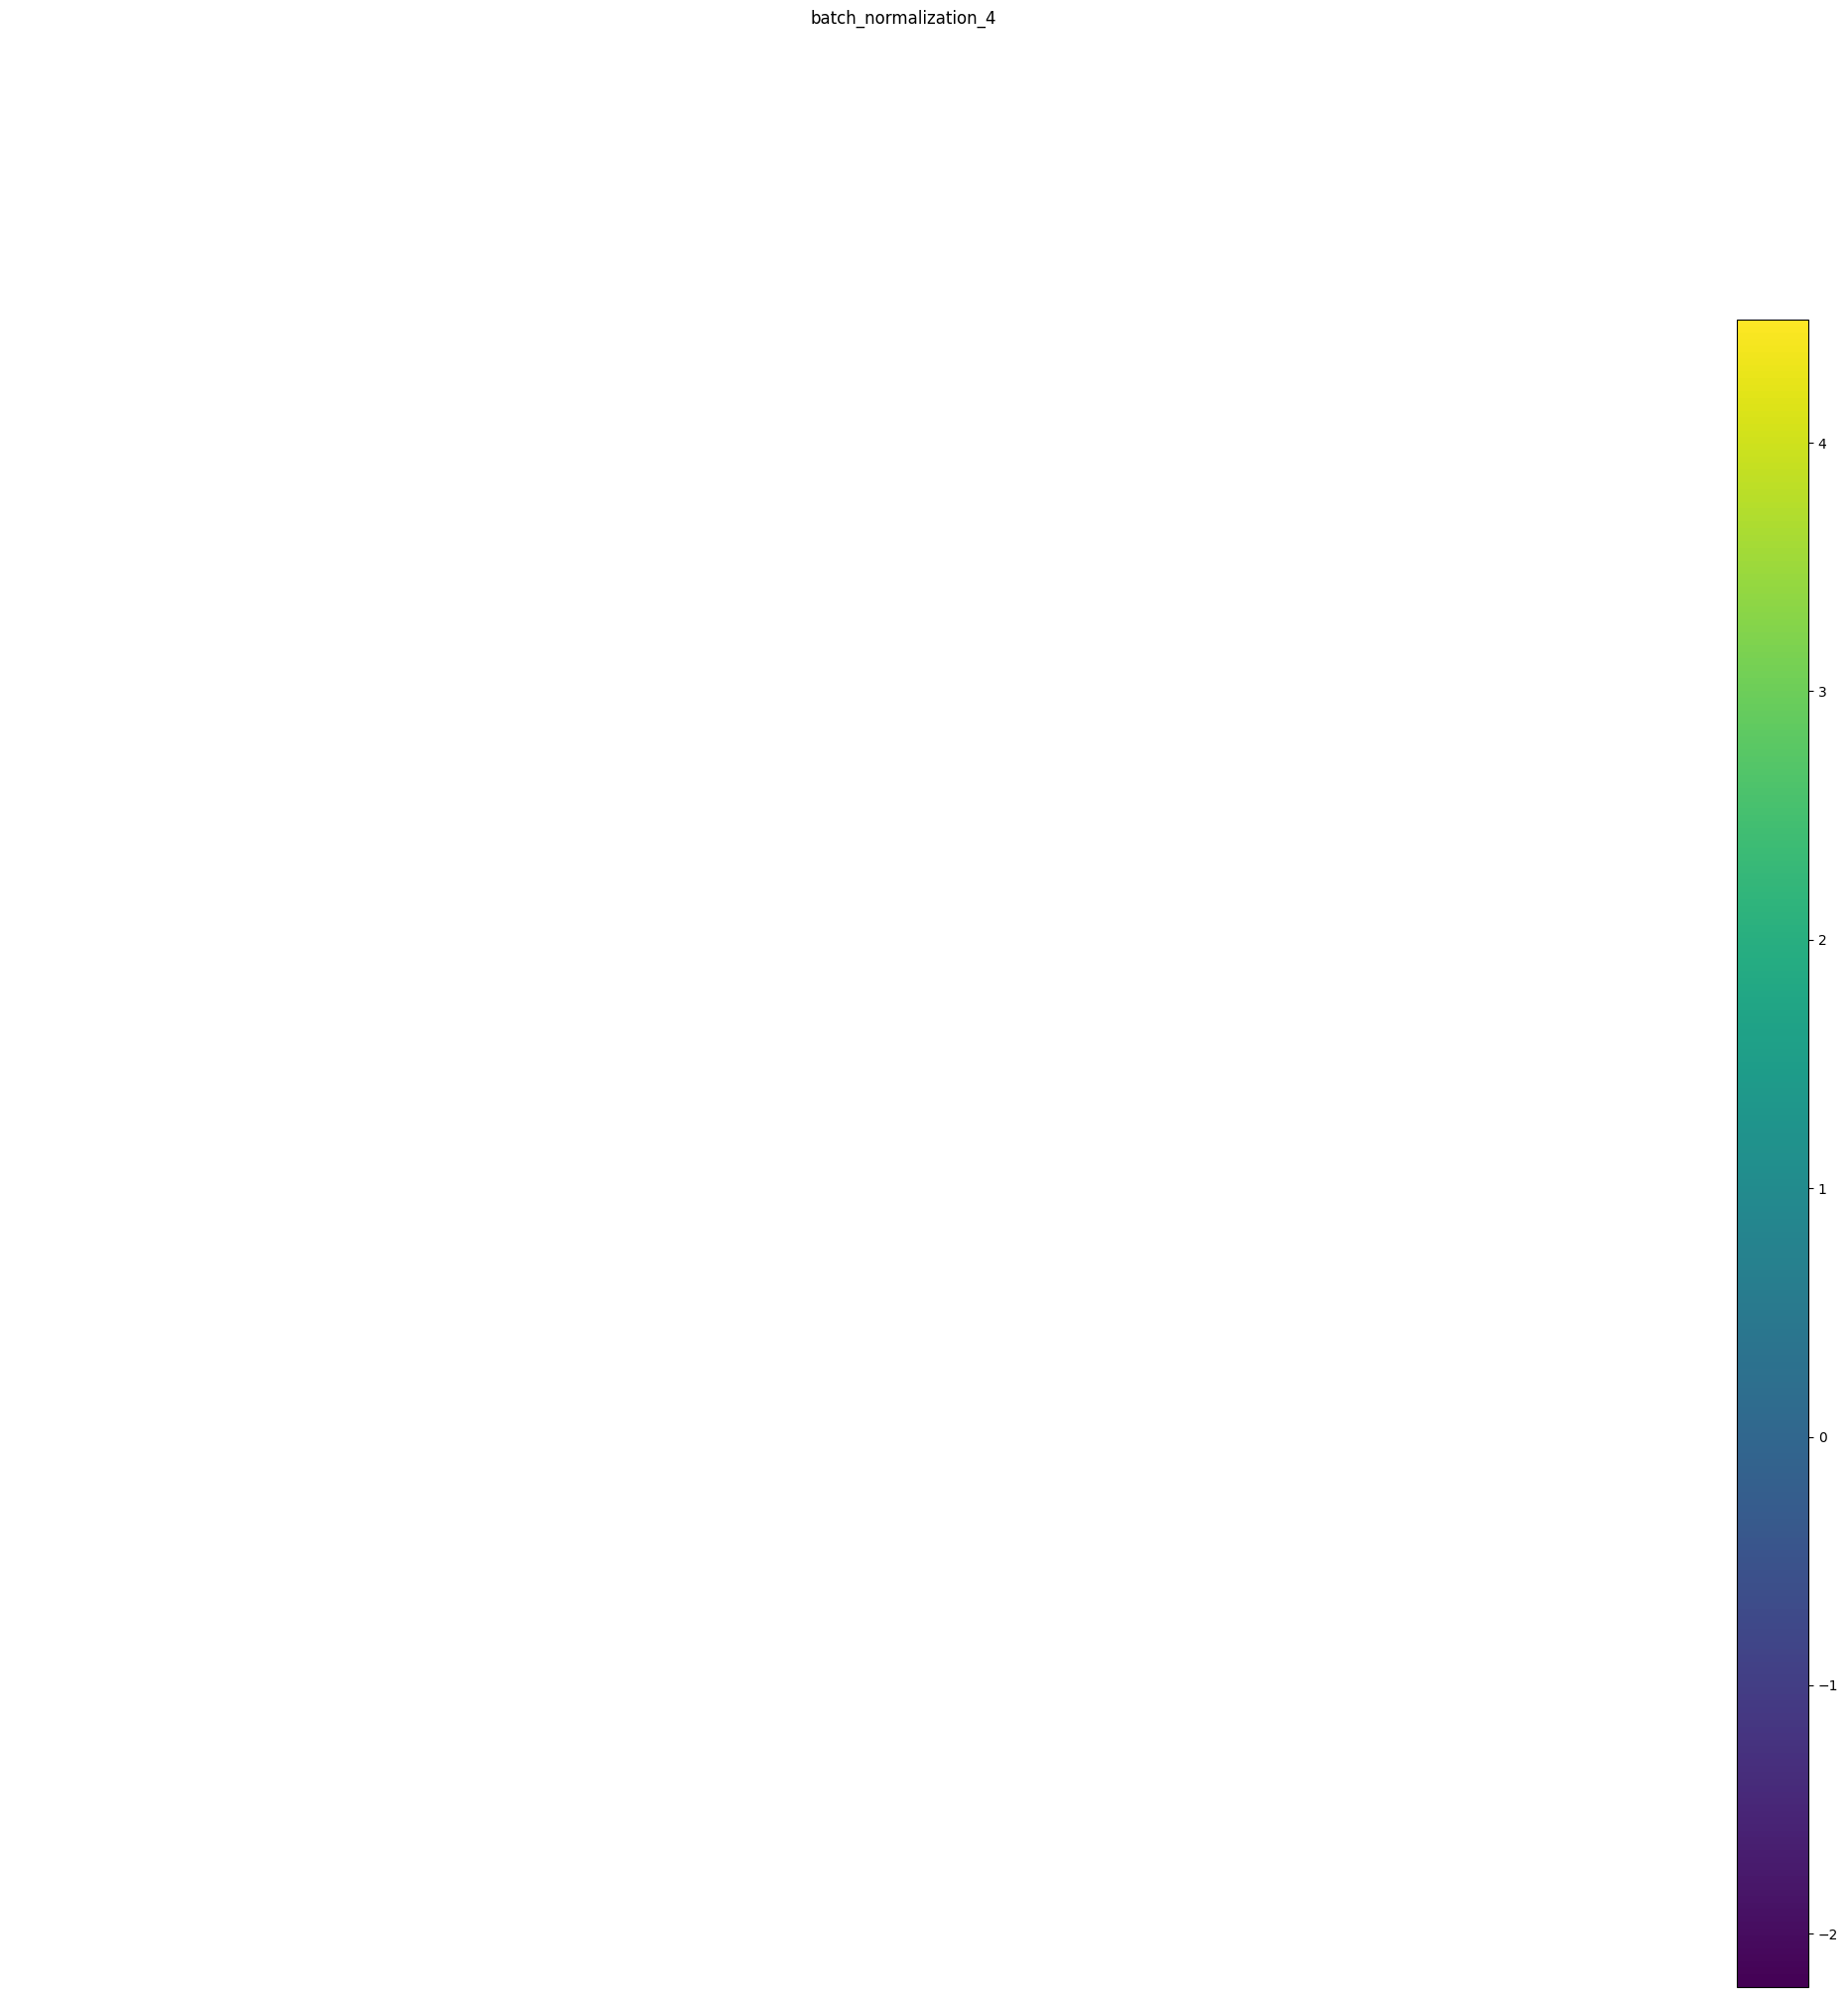

dense_6 (1, 256) 


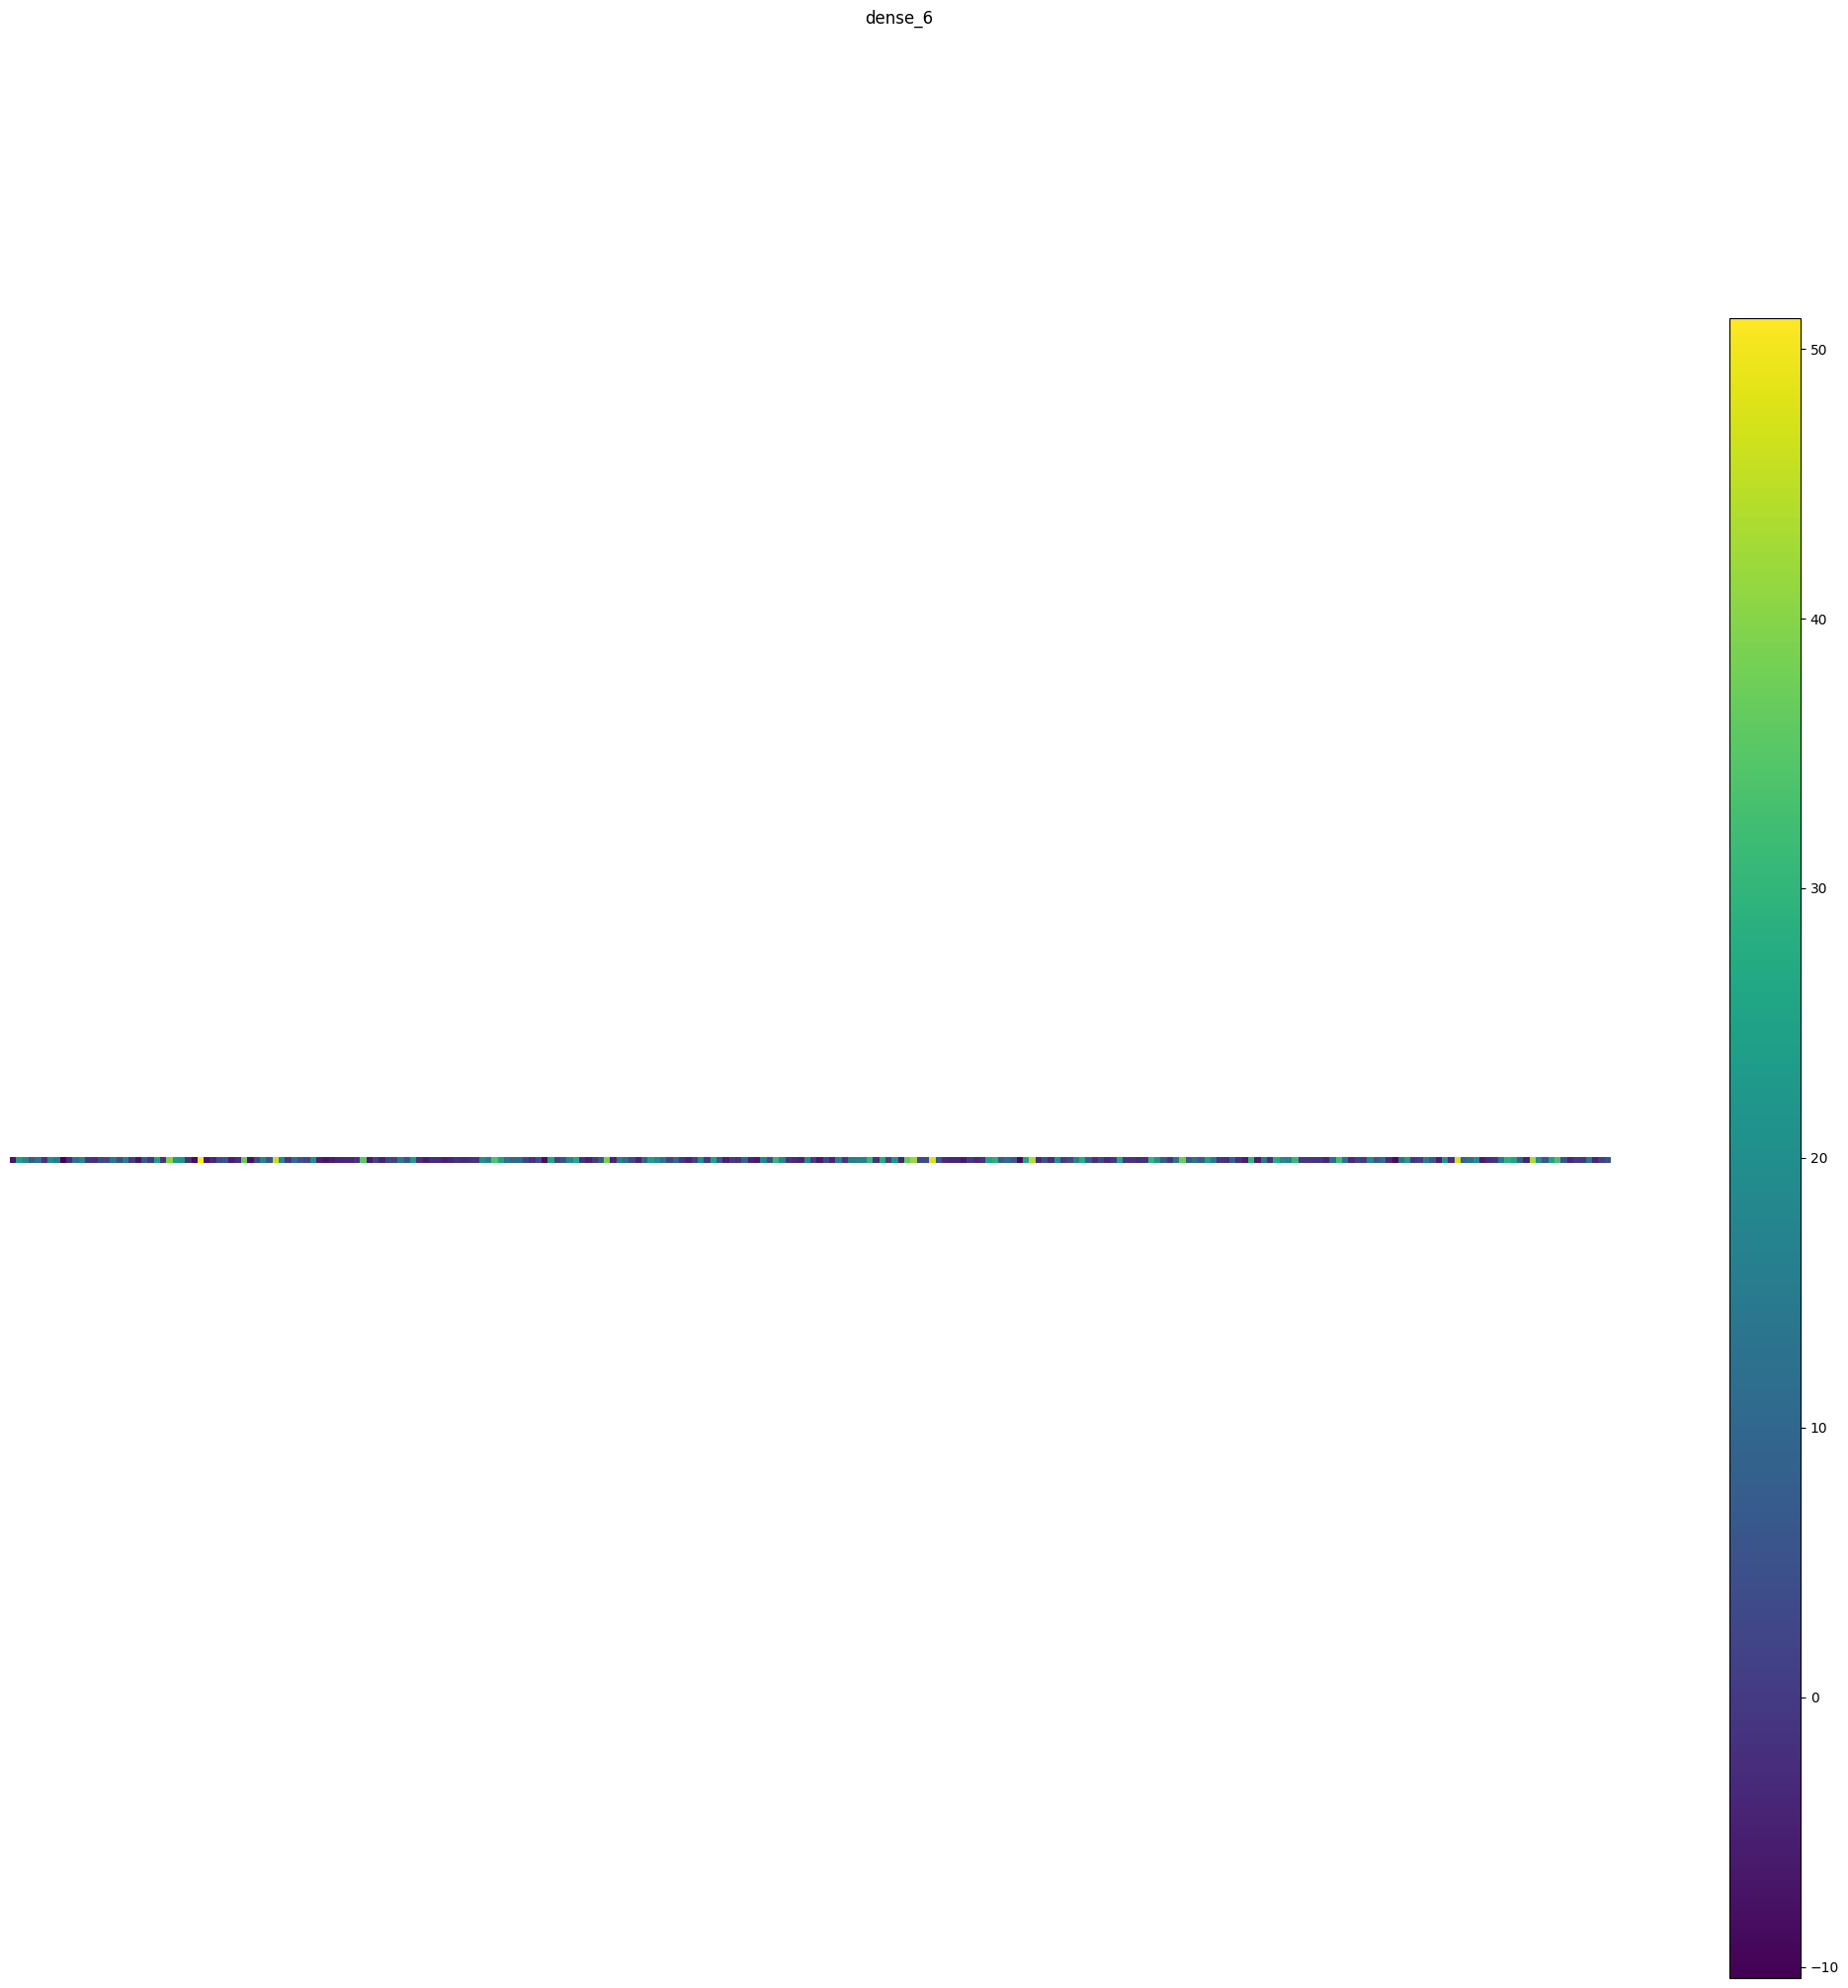

batch_normalization_5 (1, 256) 


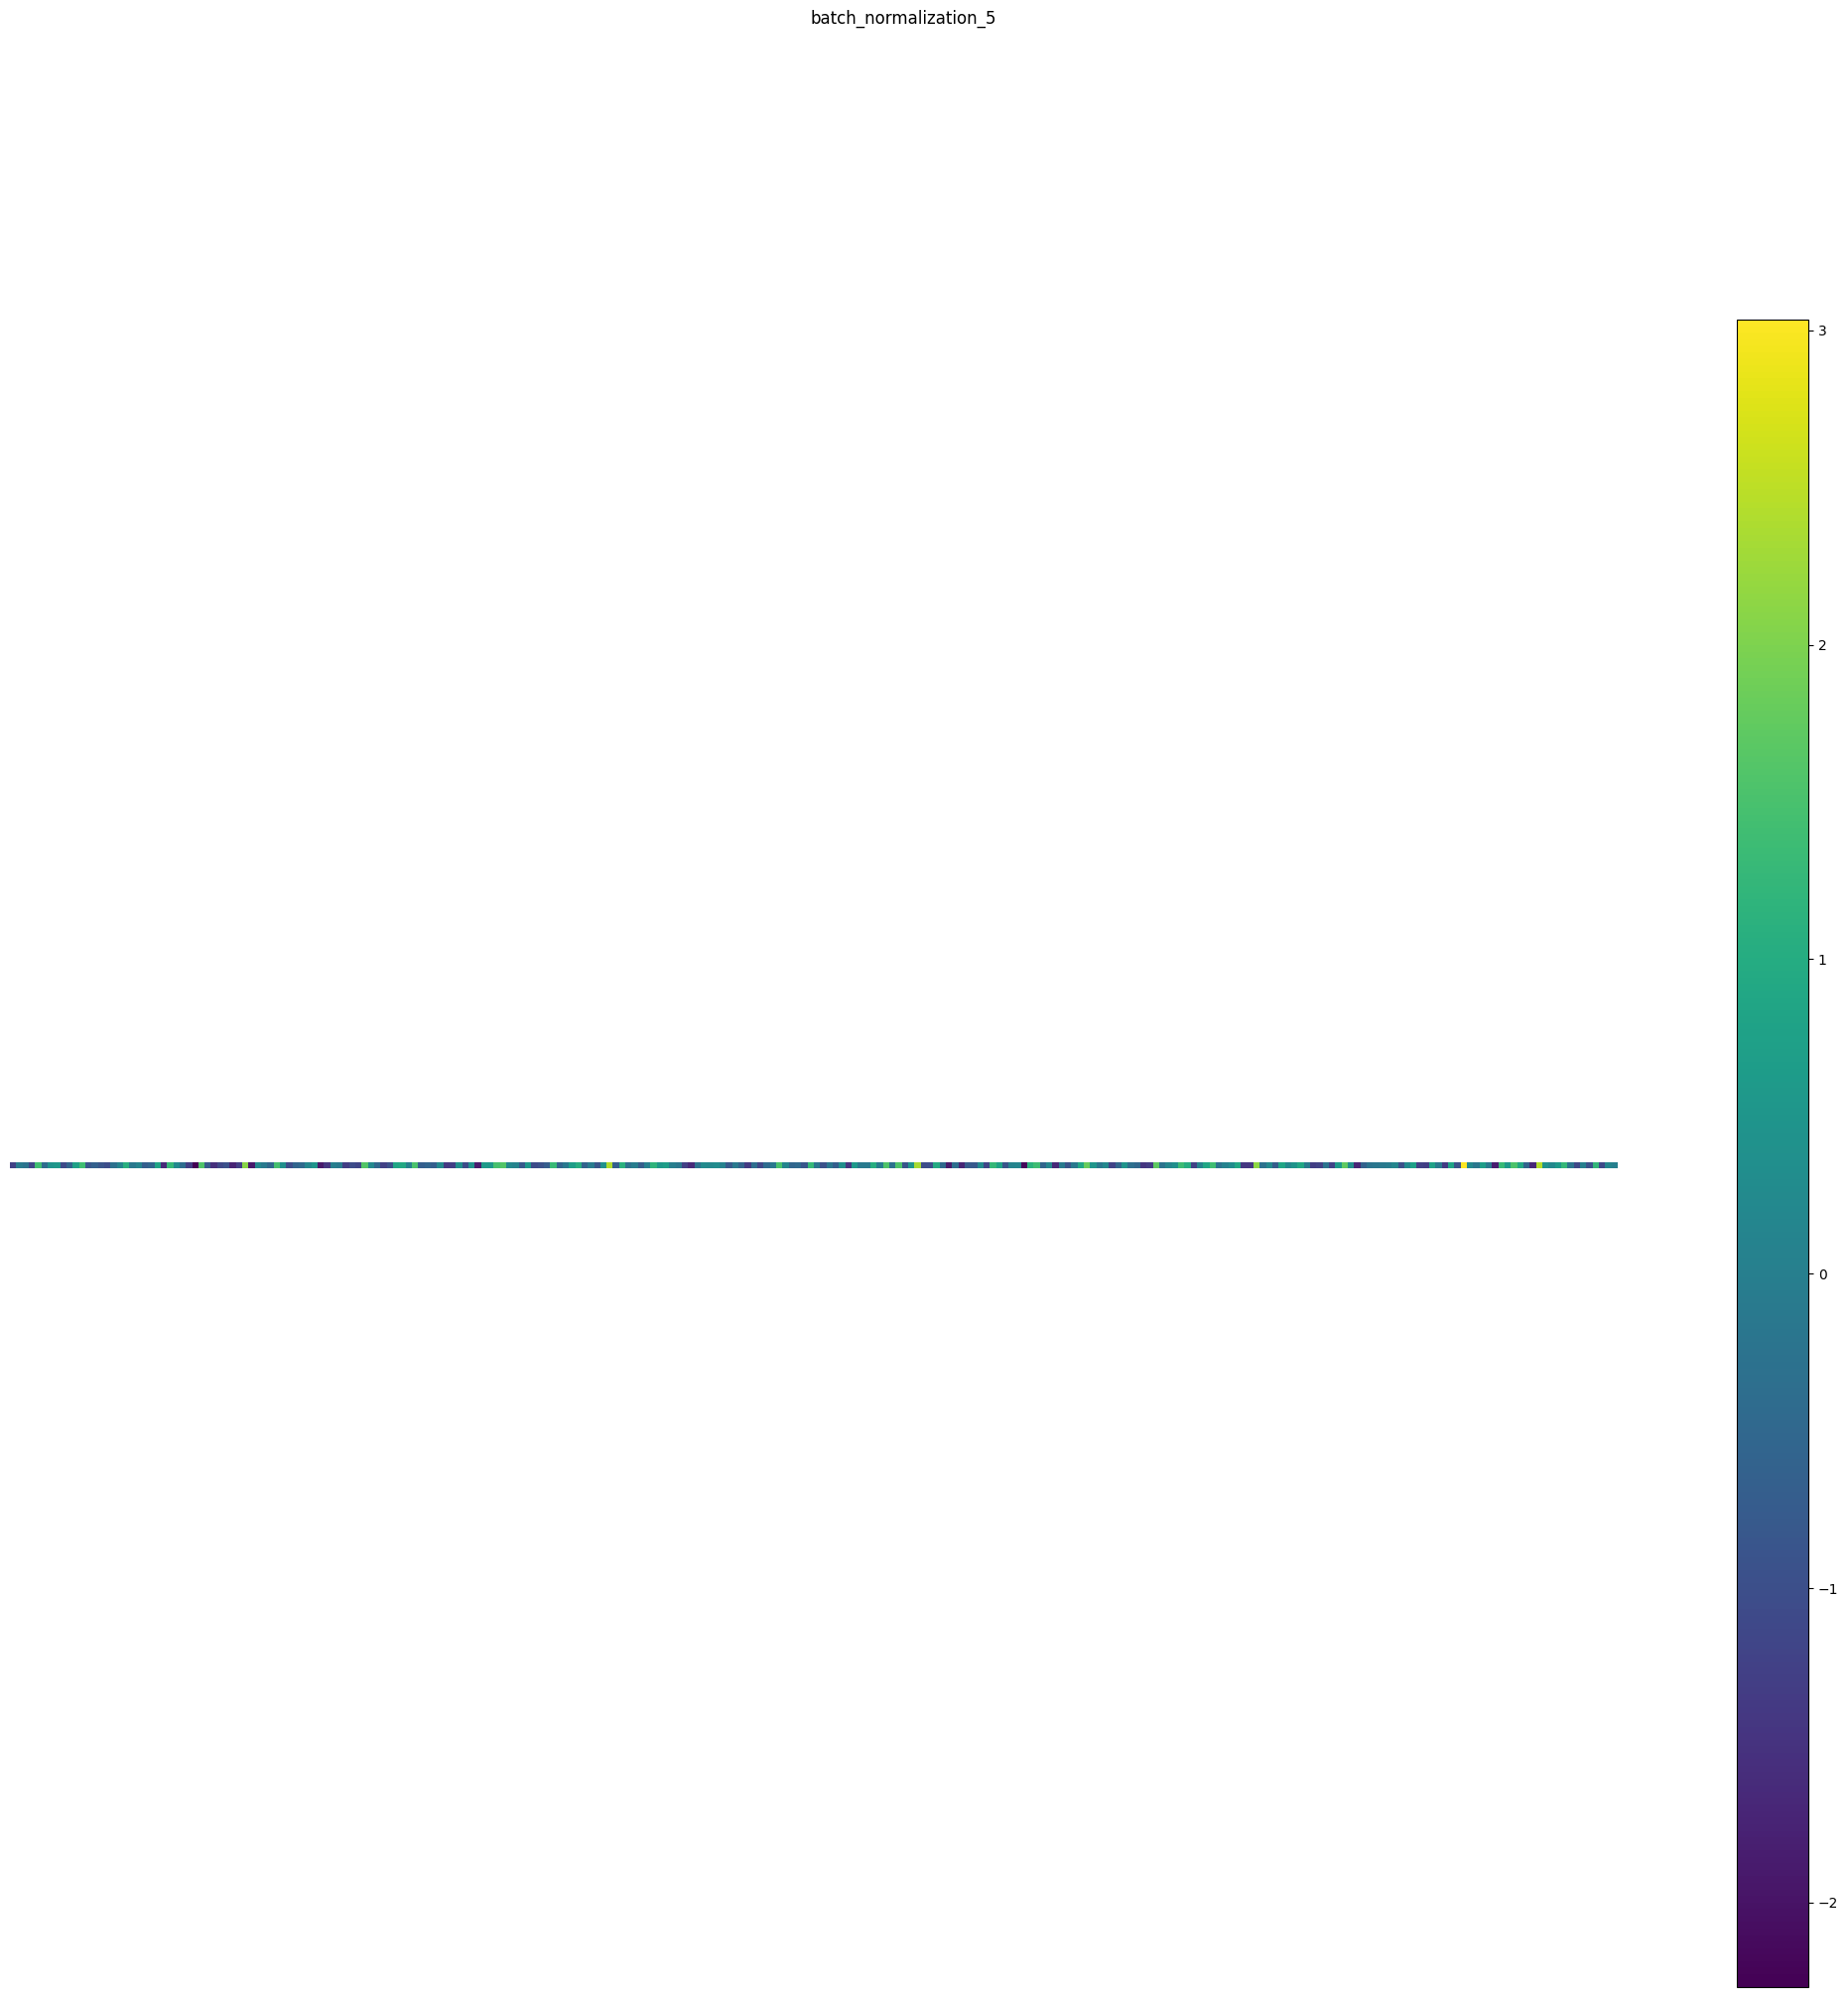

dense_7 (1, 128) 


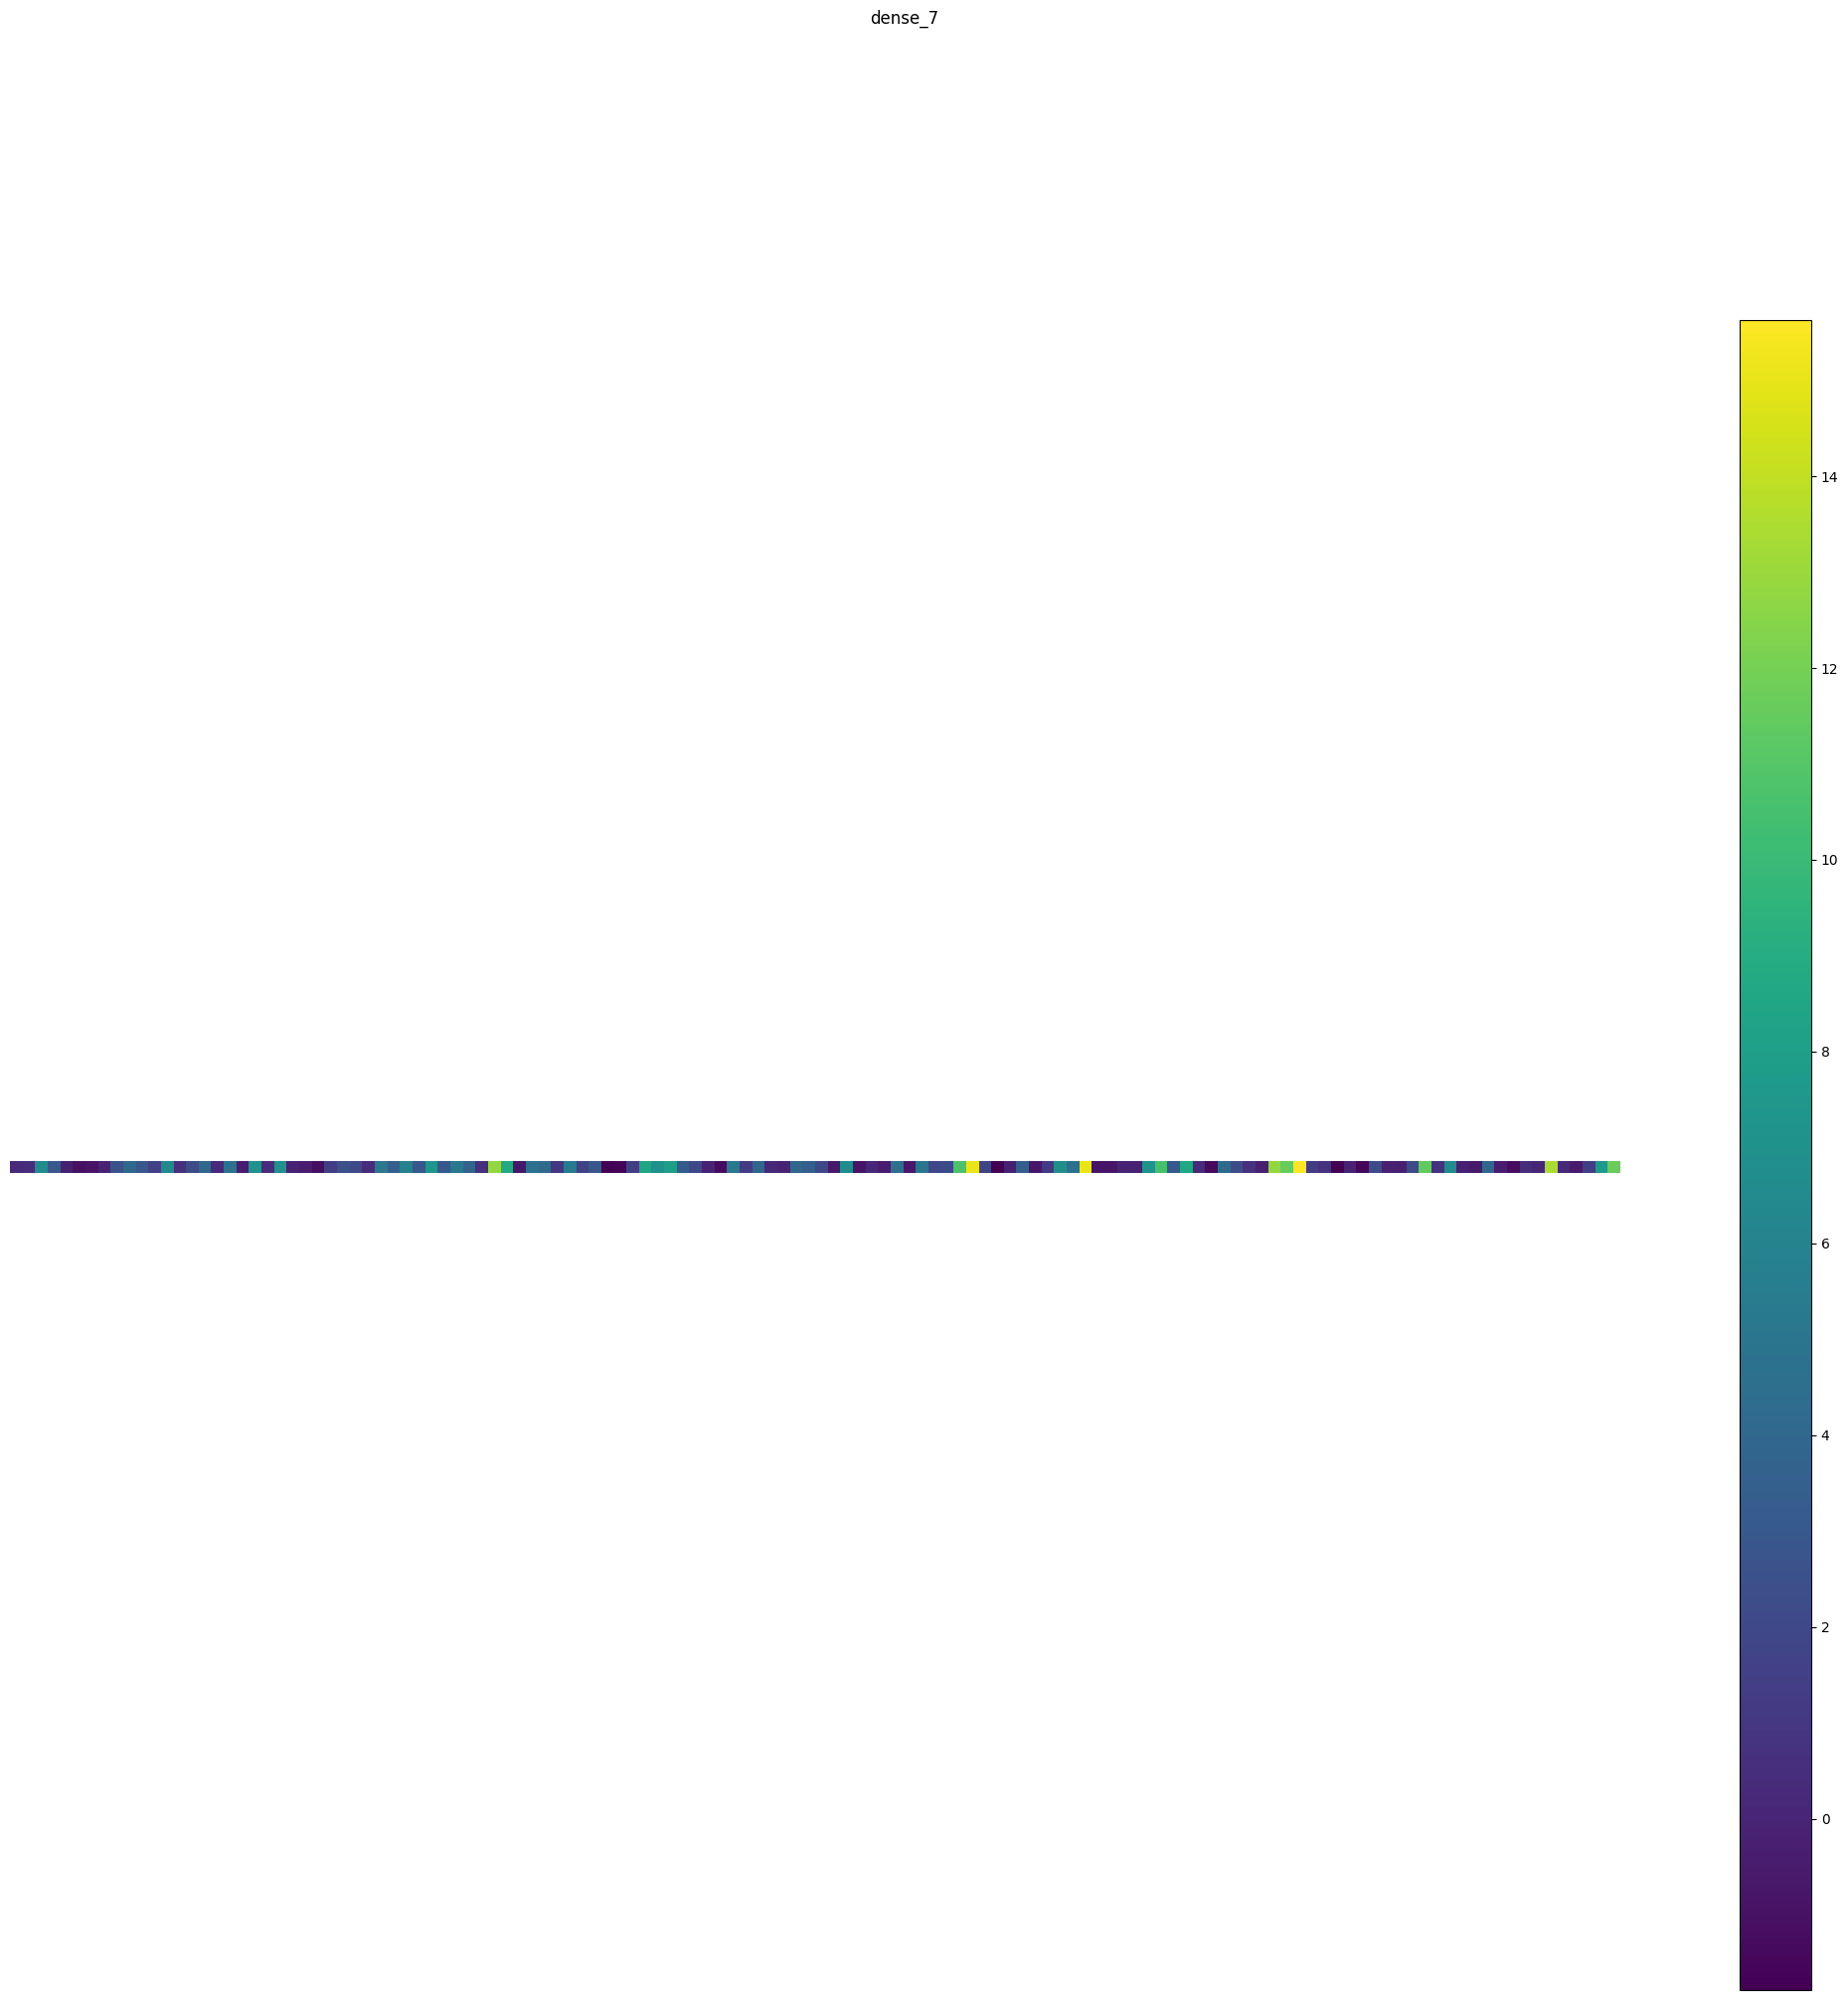

dense_8 (1, 32) 


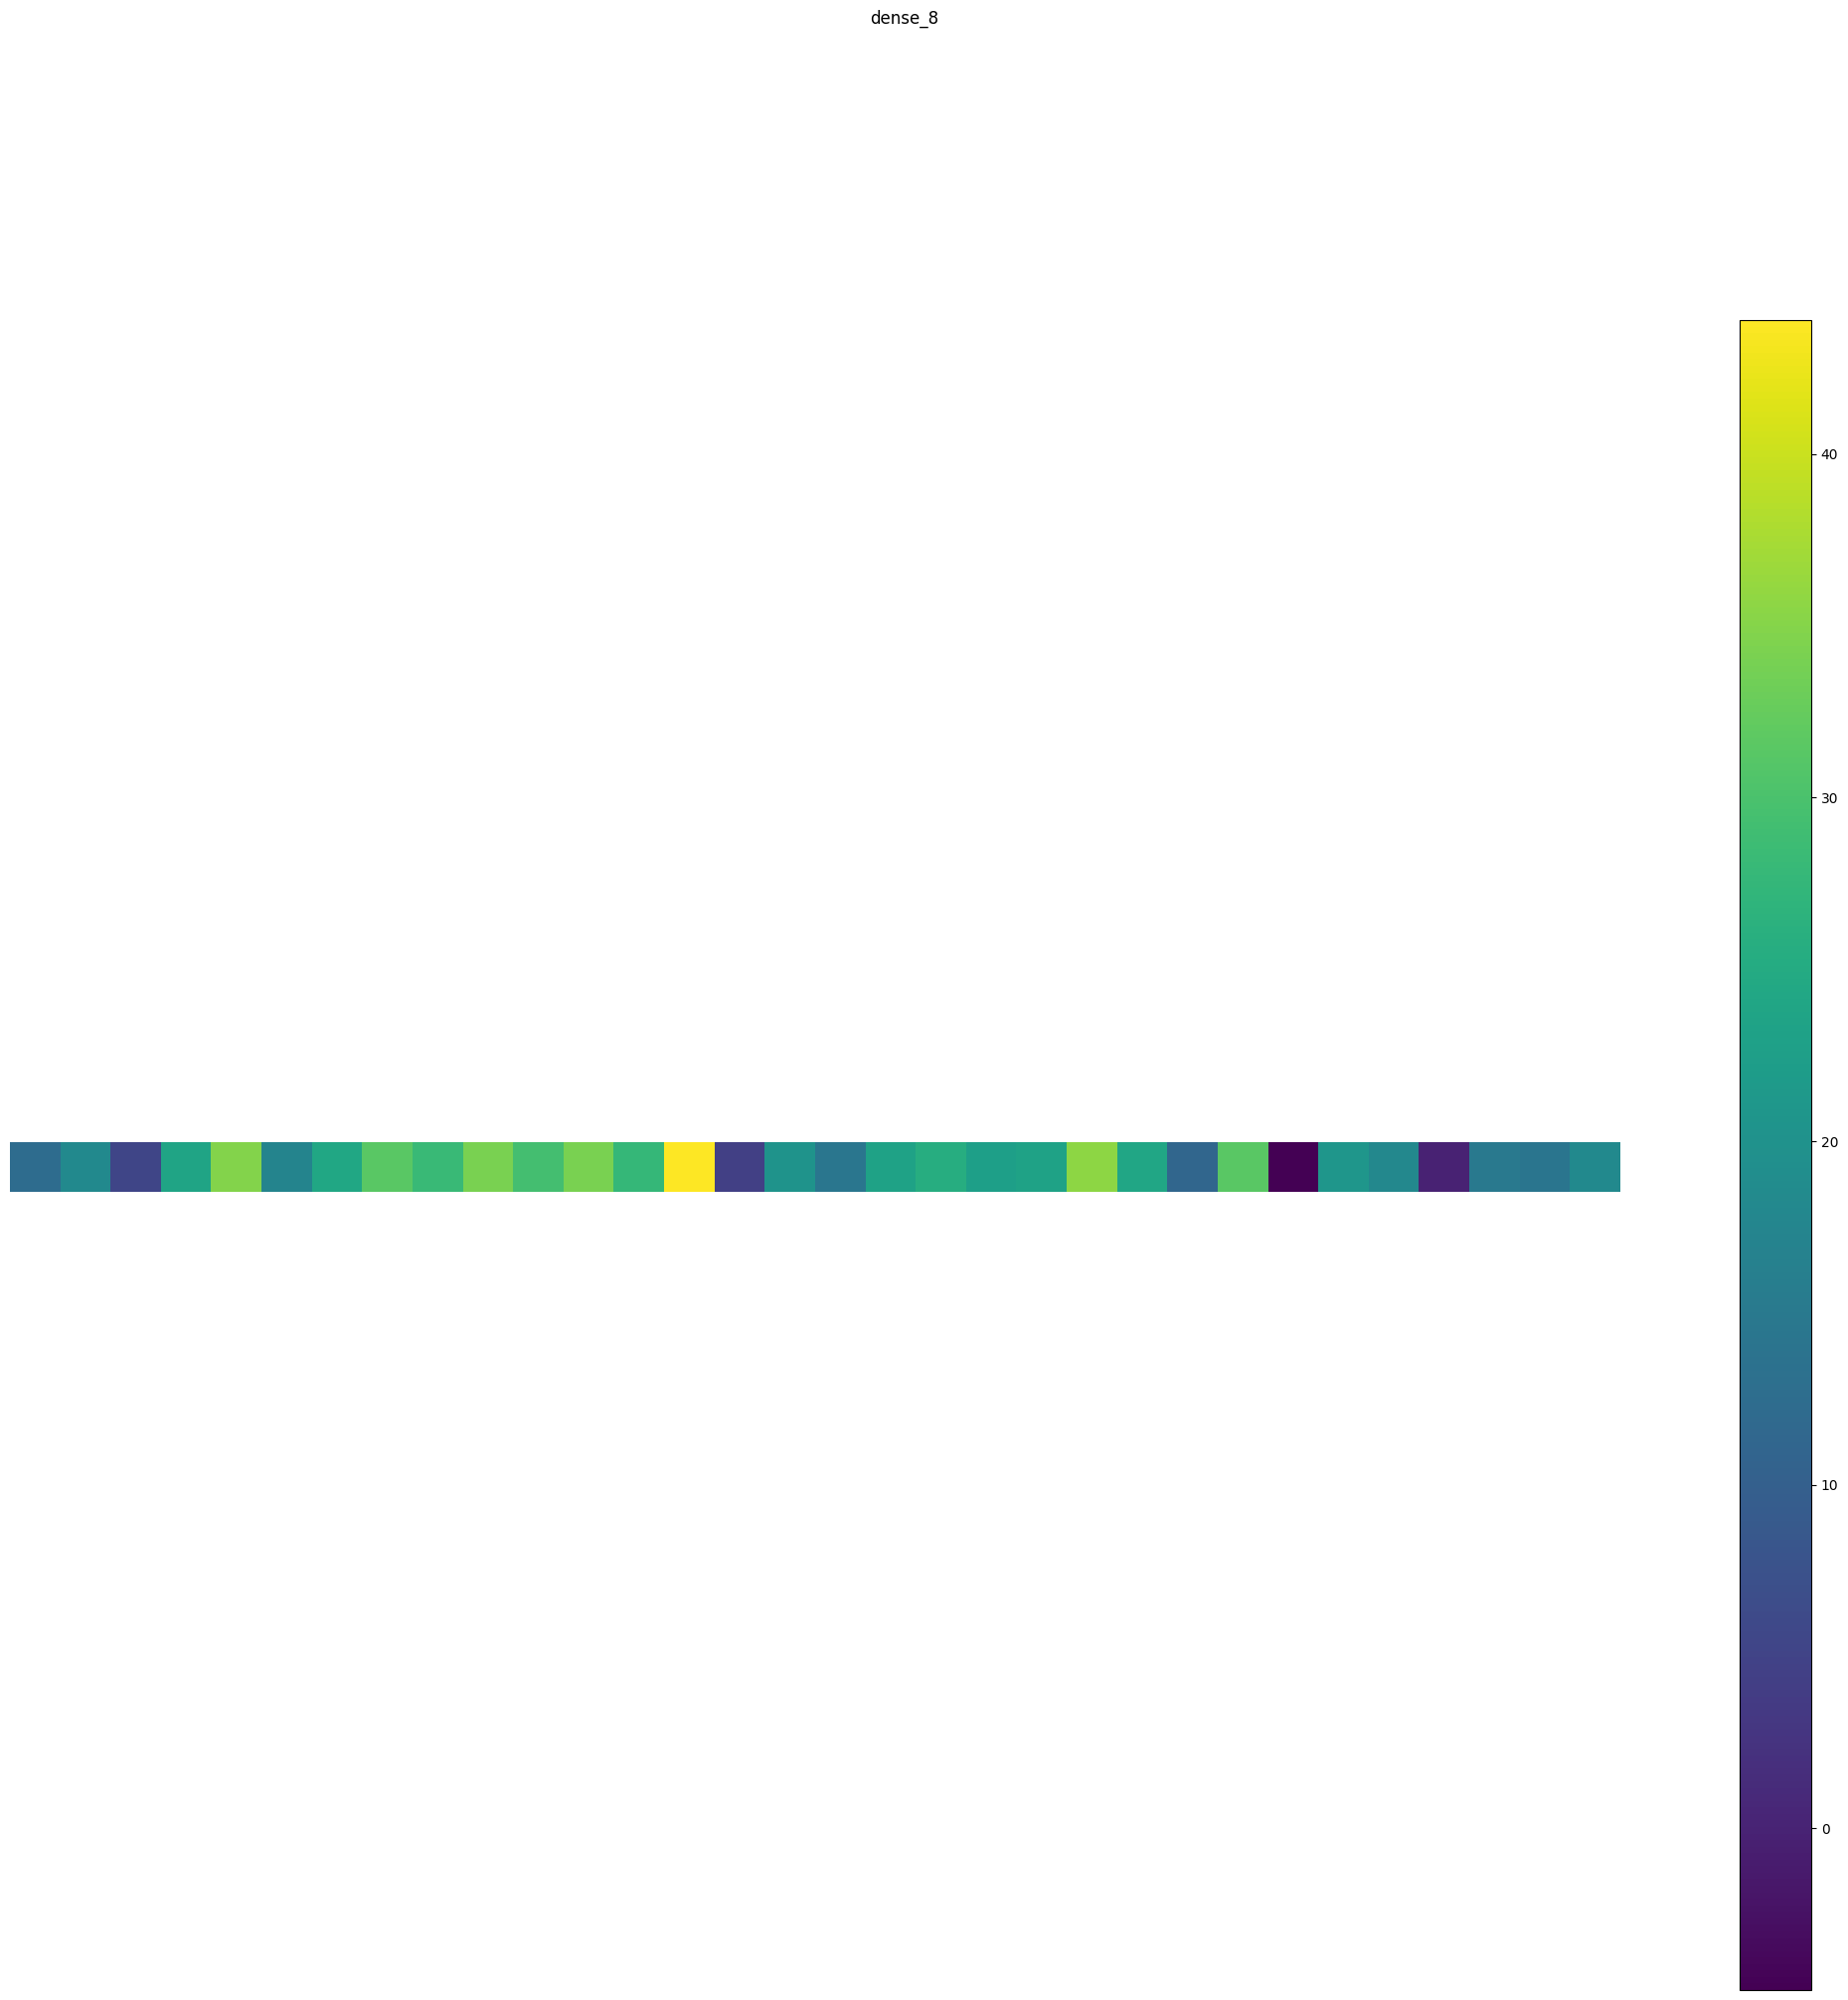

In [ ]:
display_activations(activations, save=False)

In [ ]:
# Write to feature files

fp = open("autoencoder_features_v5.txt", "w")
for i in imagePaths:
  try:
    image=plt.imread(i)
    image = image/255
    image=cv2.resize(image, (64, 64))
    fp.write(i+","+",".join(map(str, encoder(np.array([image])).numpy()[0].tolist()))+"\n")
  except:
    pass
fp.close()